In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch 
import torchvision
import pickle
import numpy as np 
import shutil
import matplotlib.pyplot as plt

import torch.optim
from scipy.io.idl import AttrDict

from PIL import Image


# IMAGE UNZIP

In [ ]:
import zipfile
import os

In [ ]:
from os import walk
_, _, filenames = next(walk("."))

for filename in filenames: 
  print(filename)
  with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(".")

# ARCHITECTURE

In [ ]:
class generator (torch.nn.Module):

  def __init__( self):
    super(generator, self).__init__()
    self.Conv1 = torch.nn.Conv2d(3, 64, 9, padding=4)

    self.residual_block = torch.nn.Sequential()
    for i in range(16):
      self.residual_block = torch.nn.Sequential(*list(self.residual_block) + [ResidualBlock()])

    self.Conv2 = torch.nn.Conv2d(64, 64, 3, padding=1 )
    self.Conv3 = torch.nn.Conv2d(64, 256, 3, padding=1 )
    self.Conv4 = torch.nn.Conv2d(64, 256, 3, padding=1 )
    self.ConvFinal = torch.nn.Conv2d(64, 3, 9, padding=4)
    self.PixelShuffle = torch.nn.PixelShuffle(upscale_factor=2)
    self.PreLU = torch.nn.PReLU();
    self.BatchNorm = torch.nn.BatchNorm2d(num_features=64)


  def forward(self, x ):

    x = self.Conv1(x)
    x = self.PreLU(x)
    
    x1 = x
    x2 = x

    self.residual_block(x1)

    x = self.Conv2(x)
    x = self.BatchNorm(x)
    x = x + x2 

    x = self.Conv3(x)
    x = self.PixelShuffle(x)
    x = self.PreLU(x)
    
    x = self.Conv4(x)
    x = self.PixelShuffle(x)
    x = self.PreLU(x)

    x = self.ConvFinal(x)
    return x 



class ResidualBlock (torch.nn.Module):
  def __init__( self):
    super(ResidualBlock, self).__init__()
    self.block = torch.nn.Sequential(
        torch.nn.Conv2d(64, 64, 3, padding=1),
        torch.nn.BatchNorm2d(64),
        torch.nn.PReLU(),
        torch.nn.Conv2d(64, 64, 3, padding=1),
        torch.nn.BatchNorm2d(64),
    )

  def forward(self, x ):
    return self.block(x) + x 



In [ ]:
class discriminator (torch.nn.Module):

  def __init__(self):
    super(discriminator, self).__init__()
    self.Conv1 = torch.nn.Conv2d(3, 64, 3)
    self.Conv2 = torch.nn.Conv2d(64, 64, 3, stride=2)
    self.BatchNorm2 = torch.nn.BatchNorm2d(num_features=64)
    self.Conv3 = torch.nn.Conv2d(64, 128, 3)
    self.BatchNorm3 = torch.nn.BatchNorm2d(num_features=128)
    self.Conv4 = torch.nn.Conv2d(128, 128, 3, 2)
    self.BatchNorm4 = torch.nn.BatchNorm2d(num_features=128)
    self.Conv5 = torch.nn.Conv2d(128, 256, kernel_size=3)
    self.BatchNorm5 = torch.nn.BatchNorm2d(num_features=256)
    self.Conv6 = torch.nn.Conv2d(256, 256, kernel_size=3,stride=2)
    self.BatchNorm6 = torch.nn.BatchNorm2d(num_features=256)
    self.Conv7 = torch.nn.Conv2d(256, 512, kernel_size=3)
    self.BatchNorm7 = torch.nn.BatchNorm2d(num_features=512)
    self.Conv8 = torch.nn.Conv2d(512, 512, kernel_size=3, stride=2)
    self.BatchNorm8 = torch.nn.BatchNorm2d(num_features=512)

    self.hidden = torch.nn.Linear(in_features=512, out_features=1024)
    self.final_classifier = torch.nn.Linear(in_features=1024, out_features=1)
    self.leakyReLU = torch.nn.LeakyReLU(negative_slope=0.2)
    self.dropout = torch.nn.Dropout(p=0.3)


  def forward(self, x ):
    x = self.leakyReLU(self.Conv1(x))
    x = self.leakyReLU(self.BatchNorm2(self.Conv2(x)))
    x = self.leakyReLU(self.BatchNorm3(self.Conv3(x)))
    x = self.dropout(x)
    x = self.leakyReLU(self.BatchNorm4(self.Conv4(x)))
    x = self.leakyReLU(self.BatchNorm5(self.Conv5(x)))
    x = self.dropout(x)
    x = self.leakyReLU(self.BatchNorm6(self.Conv6(x)))
    x = self.leakyReLU(self.BatchNorm7(self.Conv7(x)))
    x = self.leakyReLU(self.BatchNorm8(self.Conv8(x)))
    x = x.reshape((x.shape[0], -1))
    x = self.dropout(x)
    x = self.leakyReLU(self.hidden(x))
    x = self.final_classifier(x)
    return torch.sigmoid(x)

  

In [ ]:
class vgg_loss ():

  def __init__(self, device):
    super(vgg_loss, self).__init__()
    vgg = torchvision.models.vgg19(pretrained=True)
    vgg = vgg.features

    # Freeze all vgg layers 
    for param in vgg.parameters():
      param.requires_grad = False 
    
    self.vgg = vgg[:27].to(device) 
    self.MSE = torch.nn.MSELoss()

  def __call__(self, input ):
    return self.vgg(input)




# DATA LOADERS



In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict 

In [ ]:
def get_images_x64(filename):
  d = unpickle(filename)
  x = d['data']
  x = np.dstack((x[:, :4096], x[:, 4096:8192], x[:, 8192:]))
  x = x.reshape((x.shape[0], 64, 64, 3))
  return x

In [ ]:
data_dir = '/content/drive/MyDrive/CSC413/x64/'

class ImageNetSR(torch.utils.data.Dataset):

    def __init__(self, train=False,  batch=""):
        self.train = train
        self.transform = torchvision.transforms.ToTensor() 
        self.downsample = torchvision.transforms.Resize((16,16), interpolation=torchvision.transforms.InterpolationMode.BICUBIC)

        if train: 
          self.dir = data_dir + batch
        else: 
          self.dir = data_dir + "val_data" 

        self.X = get_images_x64( self.dir)
        

    def __len__(self):
        return self.X.shape[0]


    def __getitem__(self, idx):
        x = self.X[idx]
        image = self.transform(x)
        downsampled = self.downsample(image)
        sample = {'HR': image, 'LR': downsampled}
        return sample

# TRAINING CODE

## Helper Functions

In [ ]:
def gan_checkpoint(path, G, D):
    """Saves the parameters of the generator G and discriminator D.
    """
    G_path = os.path.join(path, 'G.pkl')
    D_path = os.path.join(path, 'D.pkl')
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)

def load_checkpoint(opts):
    """Loads the generator and discriminator models from checkpoints.
    """
    G_path = os.path.join(opts.load, 'G.pkl')
    D_path = os.path.join(opts.load, 'D.pkl')

    G = generator()
    D = discriminator()

    G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
    D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))

    G.to(opts.device)

    return G, D

In [ ]:
"""
CREDITS: CSC413 PA4 DCGAN
"""

def train(opts):
    """Runs the training loop.
        * Saves checkpoint every opts.checkpoint_every iterations
        * Saves generated samples every opts.sample_every iterations
    """
    # Create generators and discriminators
    G = generator().to(opts.device)
    D = discriminator().to(opts.device)

    g_params = G.parameters()  # Get generator parameters
    d_params = D.parameters()  # Get discriminator parameters

    # Create optimizers for the generators and discriminators
    g_optimizer = torch.optim.Adam(g_params, opts.lr, [opts.beta1, opts.beta2])
    d_optimizer = torch.optim.Adam(d_params, opts.lr, [opts.beta1, opts.beta2])

    print("loading training ... ")
    batch = 1 
    train_set = ImageNetSR(train=True, batch="train_data_batch_" + str(batch))
    train_loader = torch.utils.data.DataLoader(train_set, opts.batch_size,
                              shuffle=True, num_workers=opts.num_workers)

    print("loading validation ... ")
    val_set = ImageNetSR(train=False)
    val_loader = torch.utils.data.DataLoader(val_set, opts.batch_size,
                              shuffle=True, num_workers=opts.num_workers)


    train_iter = iter(train_loader)
    test_iter = iter(val_loader)

    iter_per_epoch = len(train_iter)
    total_train_iters = opts.train_iters
 
    # adversarial_loss = torch.nn.BCEWithLogitsLoss()
    gp_weight = 1

    losses ={}
    losses['iteration'] = []
    losses['D_loss'] = []
    losses['G_loss'] = []


    VGG = vgg_loss(opts.device)
    MSE = torch.nn.MSELoss()
    BCE = torch.nn.BCEWithLogitsLoss()


    data_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.ToTensor()
    ])


    image_name = "/content/drive/MyDrive/CSC413/LR_Test.jpg"
    og_image = Image.open(image_name)
    image = data_transforms(og_image).float()
    image = torch.tensor(image, requires_grad=True)

    image = image.unsqueeze(0).to(opts.device)


    try:
        for iteration in range(1, opts.train_iters + 1):

            G.train()
            g_optimizer.zero_grad()

            # Reset data_iter for each epoch
            if iteration % iter_per_epoch == 0:
              
              if batch == 10: batch = 0

              batch += 1
              print("loading train_data_batch_" + str(batch))
              train_set = ImageNetSR(train=True, batch="train_data_batch_" + str(batch))
              train_loader = torch.utils.data.DataLoader(train_set, opts.batch_size,
                                        shuffle=True, num_workers=opts.num_workers)
              train_iter = iter(train_loader)
              

            next = train_iter.next()
            HR =  next['HR']
            LR = next['LR']
            HR = HR.to(opts.device)
            LR = LR.to(opts.device)

            # ------------------------ DISCRIMINATOR LOSS ---------------------


            d_optimizer.zero_grad()
  
            HRE = G(LR)
            logits_HRE = D(HRE)
            logits_HR = D(HR)
            
            D_1 = torch.mean(logits_HR)
            D_2 = torch.mean(logits_HRE)                
            D_loss = 1 - D_1 + D_2 

            if D_loss > 0.1: 
              D_loss.backward(retain_graph=True)
              d_optimizer.step()


            # ------------------------ GENERATOR LOSS -----------------------

            g_optimizer.zero_grad()

            HRE = G(LR)
            logits_HRE = D(HRE)

            vgg_HR = VGG(HR)
            vgg_HRE = VGG(HRE)

            G_1 = torch.mean(1 - logits_HRE)
            G_VGG = MSE(vgg_HRE, vgg_HR)
            G_MSE = MSE(HRE, HR)
            G_loss = G_MSE + 0.006 * G_VGG + 0.001 * G_1 
            G_loss.backward()
            g_optimizer.step()


            # ------------------------  CHECKPOINTS & SAMPLING -------------------

            if iteration % opts.log_step == 0:
                losses['iteration'].append(iteration)
                losses['D_loss'].append(D_loss.item())
                losses['G_loss'].append(G_loss.item())
                print('Iteration [{:4d}/{:4d}] | D_loss: {:6.4f} |  G_loss: {:6.4f}'.format(
                    iteration, total_train_iters, D_loss.item(), G_loss.item()))

            # Save the model parameters
            if iteration % opts.checkpoint_every == 0:
                checkpoint = opts.checkpoint

                dir = checkpoint + str(iteration)
                if os.path.exists(dir):
                  shutil.rmtree(dir)
                os.mkdir(dir)
                gan_checkpoint(dir, G, D)

                G.eval()

                image_est = (G(image).clone().detach().cpu().numpy())
                image_est = np.squeeze(image_est, axis=0)
                image_est = np.transpose(image_est, (1,2,0) )

                f, axarr = plt.subplots(1,2)
                axarr[0].imshow(og_image)
                axarr[1].imshow(image_est)
                f.savefig(dir + '/sample.png', bbox_inches='tight')


    except KeyboardInterrupt:
        print('Exiting early from training.')
        return G, D

    return G, D

## Hyperparameters and running loop

loading training ... 
loading validation ... 


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Iteration [ 100/200000] | D_loss: 0.5548 |  G_loss: 0.0400
Iteration [ 200/200000] | D_loss: 0.0889 |  G_loss: 0.0283
Iteration [ 300/200000] | D_loss: 0.6075 |  G_loss: 0.0246
Iteration [ 400/200000] | D_loss: 0.1014 |  G_loss: 0.0242
Iteration [ 500/200000] | D_loss: 0.0430 |  G_loss: 0.0264
Iteration [ 600/200000] | D_loss: 0.0611 |  G_loss: 0.0223
Iteration [ 700/200000] | D_loss: 0.0282 |  G_loss: 0.0261
Iteration [ 800/200000] | D_loss: 0.0512 |  G_loss: 0.0211
Iteration [ 900/200000] | D_loss: 0.0329 |  G_loss: 0.0269
Iteration [1000/200000] | D_loss: 0.0691 |  G_loss: 0.0213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [1100/200000] | D_loss: 0.0351 |  G_loss: 0.0253
Iteration [1200/200000] | D_loss: 0.0282 |  G_loss: 0.0244
Iteration [1300/200000] | D_loss: 0.0412 |  G_loss: 0.0209
Iteration [1400/200000] | D_loss: 0.0295 |  G_loss: 0.0222
Iteration [1500/200000] | D_loss: 0.0269 |  G_loss: 0.0243
Iteration [1600/200000] | D_loss: 0.0196 |  G_loss: 0.0221
Iteration [1700/200000] | D_loss: 0.0409 |  G_loss: 0.0232
Iteration [1800/200000] | D_loss: 0.0230 |  G_loss: 0.0242
Iteration [1900/200000] | D_loss: 0.0350 |  G_loss: 0.0195
Iteration [2000/200000] | D_loss: 0.0467 |  G_loss: 0.0230


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [2100/200000] | D_loss: 0.0636 |  G_loss: 0.0231
Iteration [2200/200000] | D_loss: 0.0295 |  G_loss: 0.0239
Iteration [2300/200000] | D_loss: 0.0288 |  G_loss: 0.0220
Iteration [2400/200000] | D_loss: 0.0259 |  G_loss: 0.0212
Iteration [2500/200000] | D_loss: 0.0341 |  G_loss: 0.0202
Iteration [2600/200000] | D_loss: 0.0227 |  G_loss: 0.0246
Iteration [2700/200000] | D_loss: 0.0168 |  G_loss: 0.0236
Iteration [2800/200000] | D_loss: 0.0280 |  G_loss: 0.0217
Iteration [2900/200000] | D_loss: 0.0330 |  G_loss: 0.0176
Iteration [3000/200000] | D_loss: 0.0505 |  G_loss: 0.0217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [3100/200000] | D_loss: 0.0403 |  G_loss: 0.0209
Iteration [3200/200000] | D_loss: 0.0303 |  G_loss: 0.0207
Iteration [3300/200000] | D_loss: 0.0131 |  G_loss: 0.0196
Iteration [3400/200000] | D_loss: 0.0293 |  G_loss: 0.0220
Iteration [3500/200000] | D_loss: 0.0468 |  G_loss: 0.0241
Iteration [3600/200000] | D_loss: 0.0345 |  G_loss: 0.0196
Iteration [3700/200000] | D_loss: 0.0398 |  G_loss: 0.0190
Iteration [3800/200000] | D_loss: 0.0460 |  G_loss: 0.0205
Iteration [3900/200000] | D_loss: 0.0249 |  G_loss: 0.0226
Iteration [4000/200000] | D_loss: 0.0597 |  G_loss: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_2
Iteration [4100/200000] | D_loss: 0.0510 |  G_loss: 0.0210
Iteration [4200/200000] | D_loss: 0.0200 |  G_loss: 0.0206
Iteration [4300/200000] | D_loss: 0.0177 |  G_loss: 0.0217
Iteration [4400/200000] | D_loss: 0.0219 |  G_loss: 0.0179
Iteration [4500/200000] | D_loss: 0.0210 |  G_loss: 0.0234
Iteration [4600/200000] | D_loss: 0.0404 |  G_loss: 0.0211
Iteration [4700/200000] | D_loss: 0.0220 |  G_loss: 0.0193
Iteration [4800/200000] | D_loss: 0.0204 |  G_loss: 0.0207
Iteration [4900/200000] | D_loss: 0.0324 |  G_loss: 0.0223
Iteration [5000/200000] | D_loss: 0.0143 |  G_loss: 0.0217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [5100/200000] | D_loss: 0.0189 |  G_loss: 0.0207
Iteration [5200/200000] | D_loss: 0.0362 |  G_loss: 0.0226
Iteration [5300/200000] | D_loss: 0.0718 |  G_loss: 0.0215
Iteration [5400/200000] | D_loss: 0.0516 |  G_loss: 0.0205
Iteration [5500/200000] | D_loss: 0.0378 |  G_loss: 0.0187
Iteration [5600/200000] | D_loss: 0.0376 |  G_loss: 0.0203
Iteration [5700/200000] | D_loss: 0.0391 |  G_loss: 0.0193
Iteration [5800/200000] | D_loss: 0.0291 |  G_loss: 0.0203
Iteration [5900/200000] | D_loss: 0.0209 |  G_loss: 0.0205
Iteration [6000/200000] | D_loss: 0.0379 |  G_loss: 0.0192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [6100/200000] | D_loss: 0.0380 |  G_loss: 0.0194
Iteration [6200/200000] | D_loss: 0.0448 |  G_loss: 0.0202
Iteration [6300/200000] | D_loss: 0.0310 |  G_loss: 0.0196
Iteration [6400/200000] | D_loss: 0.0182 |  G_loss: 0.0180
Iteration [6500/200000] | D_loss: 0.0203 |  G_loss: 0.0179
Iteration [6600/200000] | D_loss: 0.0283 |  G_loss: 0.0178
Iteration [6700/200000] | D_loss: 0.0310 |  G_loss: 0.0193
Iteration [6800/200000] | D_loss: 0.0186 |  G_loss: 0.0190
Iteration [6900/200000] | D_loss: 0.0285 |  G_loss: 0.0188
Iteration [7000/200000] | D_loss: 0.0342 |  G_loss: 0.0212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [7100/200000] | D_loss: 0.0249 |  G_loss: 0.0203
Iteration [7200/200000] | D_loss: 0.0322 |  G_loss: 0.0206
Iteration [7300/200000] | D_loss: 0.0343 |  G_loss: 0.0216
Iteration [7400/200000] | D_loss: 0.0238 |  G_loss: 0.0185
Iteration [7500/200000] | D_loss: 0.0314 |  G_loss: 0.0216
Iteration [7600/200000] | D_loss: 0.0314 |  G_loss: 0.0201
Iteration [7700/200000] | D_loss: 0.0474 |  G_loss: 0.0198
Iteration [7800/200000] | D_loss: 0.0424 |  G_loss: 0.0209
Iteration [7900/200000] | D_loss: 0.0219 |  G_loss: 0.0193
Iteration [8000/200000] | D_loss: 0.0319 |  G_loss: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_3
Iteration [8100/200000] | D_loss: 0.0240 |  G_loss: 0.0237
Iteration [8200/200000] | D_loss: 0.0306 |  G_loss: 0.0198
Iteration [8300/200000] | D_loss: 0.0246 |  G_loss: 0.0186
Iteration [8400/200000] | D_loss: 0.0365 |  G_loss: 0.0208
Iteration [8500/200000] | D_loss: 0.0242 |  G_loss: 0.0198
Iteration [8600/200000] | D_loss: 0.0442 |  G_loss: 0.0221
Iteration [8700/200000] | D_loss: 0.0280 |  G_loss: 0.0187
Iteration [8800/200000] | D_loss: 0.0229 |  G_loss: 0.0204
Iteration [8900/200000] | D_loss: 0.0225 |  G_loss: 0.0185
Iteration [9000/200000] | D_loss: 0.0171 |  G_loss: 0.0210


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [9100/200000] | D_loss: 0.0144 |  G_loss: 0.0215
Iteration [9200/200000] | D_loss: 0.0209 |  G_loss: 0.0223
Iteration [9300/200000] | D_loss: 0.0225 |  G_loss: 0.0209
Iteration [9400/200000] | D_loss: 0.0251 |  G_loss: 0.0196
Iteration [9500/200000] | D_loss: 0.0145 |  G_loss: 0.0225
Iteration [9600/200000] | D_loss: 0.0186 |  G_loss: 0.0202
Iteration [9700/200000] | D_loss: 0.0122 |  G_loss: 0.0191
Iteration [9800/200000] | D_loss: 0.0237 |  G_loss: 0.0204
Iteration [9900/200000] | D_loss: 0.0287 |  G_loss: 0.0206
Iteration [10000/200000] | D_loss: 0.0430 |  G_loss: 0.0216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [10100/200000] | D_loss: 0.0455 |  G_loss: 0.0233
Iteration [10200/200000] | D_loss: 0.0266 |  G_loss: 0.0185
Iteration [10300/200000] | D_loss: 0.0207 |  G_loss: 0.0201
Iteration [10400/200000] | D_loss: 0.0271 |  G_loss: 0.0202
Iteration [10500/200000] | D_loss: 0.0168 |  G_loss: 0.0204
Iteration [10600/200000] | D_loss: 0.0159 |  G_loss: 0.0184
Iteration [10700/200000] | D_loss: 0.0189 |  G_loss: 0.0169
Iteration [10800/200000] | D_loss: 0.0166 |  G_loss: 0.0211
Iteration [10900/200000] | D_loss: 0.0169 |  G_loss: 0.0184
Iteration [11000/200000] | D_loss: 0.0271 |  G_loss: 0.0189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [11100/200000] | D_loss: 0.0261 |  G_loss: 0.0200
Iteration [11200/200000] | D_loss: 0.0207 |  G_loss: 0.0201
Iteration [11300/200000] | D_loss: 0.0180 |  G_loss: 0.0182
Iteration [11400/200000] | D_loss: 0.0176 |  G_loss: 0.0215
Iteration [11500/200000] | D_loss: 0.0226 |  G_loss: 0.0177
Iteration [11600/200000] | D_loss: 0.0326 |  G_loss: 0.0203
Iteration [11700/200000] | D_loss: 0.0125 |  G_loss: 0.0187
Iteration [11800/200000] | D_loss: 0.0202 |  G_loss: 0.0202
Iteration [11900/200000] | D_loss: 0.0334 |  G_loss: 0.0222
Iteration [12000/200000] | D_loss: 0.0474 |  G_loss: 0.0191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_4
Iteration [12100/200000] | D_loss: 0.0125 |  G_loss: 0.0222
Iteration [12200/200000] | D_loss: 0.0204 |  G_loss: 0.0216
Iteration [12300/200000] | D_loss: 0.0170 |  G_loss: 0.0186
Iteration [12400/200000] | D_loss: 0.0167 |  G_loss: 0.0207
Iteration [12500/200000] | D_loss: 0.0210 |  G_loss: 0.0219
Iteration [12600/200000] | D_loss: 0.0166 |  G_loss: 0.0216
Iteration [12700/200000] | D_loss: 0.0221 |  G_loss: 0.0214
Iteration [12800/200000] | D_loss: 0.0169 |  G_loss: 0.0208
Iteration [12900/200000] | D_loss: 0.0269 |  G_loss: 0.0208
Iteration [13000/200000] | D_loss: 0.0214 |  G_loss: 0.0189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [13100/200000] | D_loss: 0.0146 |  G_loss: 0.0219
Iteration [13200/200000] | D_loss: 0.0193 |  G_loss: 0.0188
Iteration [13300/200000] | D_loss: 0.0186 |  G_loss: 0.0177
Iteration [13400/200000] | D_loss: 0.0211 |  G_loss: 0.0169
Iteration [13500/200000] | D_loss: 0.0168 |  G_loss: 0.0200
Iteration [13600/200000] | D_loss: 0.0142 |  G_loss: 0.0188
Iteration [13700/200000] | D_loss: 0.0151 |  G_loss: 0.0184
Iteration [13800/200000] | D_loss: 0.0164 |  G_loss: 0.0205
Iteration [13900/200000] | D_loss: 0.0180 |  G_loss: 0.0199
Iteration [14000/200000] | D_loss: 0.0195 |  G_loss: 0.0183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [14100/200000] | D_loss: 0.0303 |  G_loss: 0.0201
Iteration [14200/200000] | D_loss: 0.0122 |  G_loss: 0.0174
Iteration [14300/200000] | D_loss: 0.0134 |  G_loss: 0.0188
Iteration [14400/200000] | D_loss: 0.0217 |  G_loss: 0.0178
Iteration [14500/200000] | D_loss: 0.0120 |  G_loss: 0.0219
Iteration [14600/200000] | D_loss: 0.0182 |  G_loss: 0.0175
Iteration [14700/200000] | D_loss: 0.0321 |  G_loss: 0.0176
Iteration [14800/200000] | D_loss: 0.0151 |  G_loss: 0.0211
Iteration [14900/200000] | D_loss: 0.0141 |  G_loss: 0.0174
Iteration [15000/200000] | D_loss: 0.0179 |  G_loss: 0.0207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [15100/200000] | D_loss: 0.0169 |  G_loss: 0.0197
Iteration [15200/200000] | D_loss: 0.0184 |  G_loss: 0.0229
Iteration [15300/200000] | D_loss: 0.0158 |  G_loss: 0.0212
Iteration [15400/200000] | D_loss: 0.0184 |  G_loss: 0.0193
Iteration [15500/200000] | D_loss: 0.0133 |  G_loss: 0.0193
Iteration [15600/200000] | D_loss: 0.0104 |  G_loss: 0.0193
Iteration [15700/200000] | D_loss: 0.0139 |  G_loss: 0.0183
Iteration [15800/200000] | D_loss: 0.0185 |  G_loss: 0.0187
Iteration [15900/200000] | D_loss: 0.0144 |  G_loss: 0.0192
Iteration [16000/200000] | D_loss: 0.0231 |  G_loss: 0.0189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_5
Iteration [16100/200000] | D_loss: 0.0236 |  G_loss: 0.0179
Iteration [16200/200000] | D_loss: 0.0270 |  G_loss: 0.0221
Iteration [16300/200000] | D_loss: 0.0111 |  G_loss: 0.0193
Iteration [16400/200000] | D_loss: 0.0170 |  G_loss: 0.0184
Iteration [16500/200000] | D_loss: 0.0174 |  G_loss: 0.0195
Iteration [16600/200000] | D_loss: 0.0134 |  G_loss: 0.0196
Iteration [16700/200000] | D_loss: 0.0132 |  G_loss: 0.0190
Iteration [16800/200000] | D_loss: 0.0159 |  G_loss: 0.0178
Iteration [16900/200000] | D_loss: 0.0138 |  G_loss: 0.0197
Iteration [17000/200000] | D_loss: 0.0163 |  G_loss: 0.0190


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [17100/200000] | D_loss: 0.0146 |  G_loss: 0.0186
Iteration [17200/200000] | D_loss: 0.0268 |  G_loss: 0.0211
Iteration [17300/200000] | D_loss: 0.0371 |  G_loss: 0.0193
Iteration [17400/200000] | D_loss: 0.0151 |  G_loss: 0.0199
Iteration [17500/200000] | D_loss: 0.0186 |  G_loss: 0.0163
Iteration [17600/200000] | D_loss: 0.0240 |  G_loss: 0.0194
Iteration [17700/200000] | D_loss: 0.0126 |  G_loss: 0.0196
Iteration [17800/200000] | D_loss: 0.0216 |  G_loss: 0.0203
Iteration [17900/200000] | D_loss: 0.0118 |  G_loss: 0.0192
Iteration [18000/200000] | D_loss: 0.0136 |  G_loss: 0.0213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [18100/200000] | D_loss: 0.0223 |  G_loss: 0.0192
Iteration [18200/200000] | D_loss: 0.0142 |  G_loss: 0.0209
Iteration [18300/200000] | D_loss: 0.0172 |  G_loss: 0.0191
Iteration [18400/200000] | D_loss: 0.0131 |  G_loss: 0.0182
Iteration [18500/200000] | D_loss: 0.0098 |  G_loss: 0.0183
Iteration [18600/200000] | D_loss: 0.0169 |  G_loss: 0.0190
Iteration [18700/200000] | D_loss: 0.0190 |  G_loss: 0.0191
Iteration [18800/200000] | D_loss: 0.0315 |  G_loss: 0.0205
Iteration [18900/200000] | D_loss: 0.0171 |  G_loss: 0.0185
Iteration [19000/200000] | D_loss: 0.0172 |  G_loss: 0.0208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [19100/200000] | D_loss: 0.0120 |  G_loss: 0.0172
Iteration [19200/200000] | D_loss: 0.0192 |  G_loss: 0.0176
Iteration [19300/200000] | D_loss: 0.0269 |  G_loss: 0.0210
Iteration [19400/200000] | D_loss: 0.0295 |  G_loss: 0.0184
Iteration [19500/200000] | D_loss: 0.0189 |  G_loss: 0.0182
Iteration [19600/200000] | D_loss: 0.0121 |  G_loss: 0.0188
Iteration [19700/200000] | D_loss: 0.0190 |  G_loss: 0.0196
Iteration [19800/200000] | D_loss: 0.0216 |  G_loss: 0.0218
Iteration [19900/200000] | D_loss: 0.0466 |  G_loss: 0.0190
Iteration [20000/200000] | D_loss: 0.0285 |  G_loss: 0.0191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_6
Iteration [20100/200000] | D_loss: 0.0199 |  G_loss: 0.0197
Iteration [20200/200000] | D_loss: 0.0171 |  G_loss: 0.0222
Iteration [20300/200000] | D_loss: 0.0147 |  G_loss: 0.0200
Iteration [20400/200000] | D_loss: 0.0160 |  G_loss: 0.0199
Iteration [20500/200000] | D_loss: 0.0157 |  G_loss: 0.0210
Iteration [20600/200000] | D_loss: 0.0201 |  G_loss: 0.0188
Iteration [20700/200000] | D_loss: 0.0168 |  G_loss: 0.0186
Iteration [20800/200000] | D_loss: 0.0127 |  G_loss: 0.0210
Iteration [20900/200000] | D_loss: 0.0488 |  G_loss: 0.0211
Iteration [21000/200000] | D_loss: 0.0096 |  G_loss: 0.0197


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:153: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [21100/200000] | D_loss: 0.0099 |  G_loss: 0.0190
Iteration [21200/200000] | D_loss: 0.0245 |  G_loss: 0.0209
Iteration [21300/200000] | D_loss: 0.0259 |  G_loss: 0.0202
Iteration [21400/200000] | D_loss: 0.0193 |  G_loss: 0.0213
Iteration [21500/200000] | D_loss: 0.0194 |  G_loss: 0.0195
Iteration [21600/200000] | D_loss: 0.0117 |  G_loss: 0.0185
Iteration [21700/200000] | D_loss: 0.0151 |  G_loss: 0.0219
Iteration [21800/200000] | D_loss: 0.0170 |  G_loss: 0.0212
Iteration [21900/200000] | D_loss: 0.0490 |  G_loss: 0.0194
Iteration [22000/200000] | D_loss: 0.0244 |  G_loss: 0.0198


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [22100/200000] | D_loss: 0.0125 |  G_loss: 0.0211
Iteration [22200/200000] | D_loss: 0.0146 |  G_loss: 0.0198
Iteration [22300/200000] | D_loss: 0.0173 |  G_loss: 0.0175
Iteration [22400/200000] | D_loss: 0.0237 |  G_loss: 0.0174
Iteration [22500/200000] | D_loss: 0.0087 |  G_loss: 0.0194
Iteration [22600/200000] | D_loss: 0.0181 |  G_loss: 0.0235
Iteration [22700/200000] | D_loss: 0.0099 |  G_loss: 0.0188
Iteration [22800/200000] | D_loss: 0.0288 |  G_loss: 0.0202
Iteration [22900/200000] | D_loss: 0.0281 |  G_loss: 0.0204
Iteration [23000/200000] | D_loss: 0.0332 |  G_loss: 0.0189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [23100/200000] | D_loss: 0.0197 |  G_loss: 0.0181
Iteration [23200/200000] | D_loss: 0.0154 |  G_loss: 0.0216
Iteration [23300/200000] | D_loss: 0.0214 |  G_loss: 0.0199
Iteration [23400/200000] | D_loss: 0.0140 |  G_loss: 0.0181
Iteration [23500/200000] | D_loss: 0.0280 |  G_loss: 0.0175
Iteration [23600/200000] | D_loss: 0.0117 |  G_loss: 0.0201
Iteration [23700/200000] | D_loss: 0.0129 |  G_loss: 0.0176
Iteration [23800/200000] | D_loss: 0.0301 |  G_loss: 0.0186
Iteration [23900/200000] | D_loss: 0.0228 |  G_loss: 0.0186
Iteration [24000/200000] | D_loss: 0.0161 |  G_loss: 0.0193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_7
Iteration [24100/200000] | D_loss: 0.0230 |  G_loss: 0.0222
Iteration [24200/200000] | D_loss: 0.0200 |  G_loss: 0.0215
Iteration [24300/200000] | D_loss: 0.0111 |  G_loss: 0.0194
Iteration [24400/200000] | D_loss: 0.0144 |  G_loss: 0.0180
Iteration [24500/200000] | D_loss: 0.0211 |  G_loss: 0.0187
Iteration [24600/200000] | D_loss: 0.0117 |  G_loss: 0.0176
Iteration [24700/200000] | D_loss: 0.0145 |  G_loss: 0.0209
Iteration [24800/200000] | D_loss: 0.0241 |  G_loss: 0.0196
Iteration [24900/200000] | D_loss: 0.0171 |  G_loss: 0.0173
Iteration [25000/200000] | D_loss: 0.0134 |  G_loss: 0.0191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [25100/200000] | D_loss: 0.0166 |  G_loss: 0.0154
Iteration [25200/200000] | D_loss: 0.0249 |  G_loss: 0.0164
Iteration [25300/200000] | D_loss: 0.0168 |  G_loss: 0.0174
Iteration [25400/200000] | D_loss: 0.0189 |  G_loss: 0.0217
Iteration [25500/200000] | D_loss: 0.0327 |  G_loss: 0.0191
Iteration [25600/200000] | D_loss: 0.0144 |  G_loss: 0.0201
Iteration [25700/200000] | D_loss: 0.0140 |  G_loss: 0.0207
Iteration [25800/200000] | D_loss: 0.0182 |  G_loss: 0.0189
Iteration [25900/200000] | D_loss: 0.0286 |  G_loss: 0.0173
Iteration [26000/200000] | D_loss: 0.0113 |  G_loss: 0.0201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [26100/200000] | D_loss: 0.0171 |  G_loss: 0.0181
Iteration [26200/200000] | D_loss: 0.0186 |  G_loss: 0.0213
Iteration [26300/200000] | D_loss: 0.0167 |  G_loss: 0.0189
Iteration [26400/200000] | D_loss: 0.0190 |  G_loss: 0.0201
Iteration [26500/200000] | D_loss: 0.0128 |  G_loss: 0.0201
Iteration [26600/200000] | D_loss: 0.0257 |  G_loss: 0.0189
Iteration [26700/200000] | D_loss: 0.0229 |  G_loss: 0.0212
Iteration [26800/200000] | D_loss: 0.0106 |  G_loss: 0.0192
Iteration [26900/200000] | D_loss: 0.0127 |  G_loss: 0.0201
Iteration [27000/200000] | D_loss: 0.0159 |  G_loss: 0.0184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [27100/200000] | D_loss: 0.0180 |  G_loss: 0.0172
Iteration [27200/200000] | D_loss: 0.0096 |  G_loss: 0.0197
Iteration [27300/200000] | D_loss: 0.0156 |  G_loss: 0.0193
Iteration [27400/200000] | D_loss: 0.0125 |  G_loss: 0.0205
Iteration [27500/200000] | D_loss: 0.0184 |  G_loss: 0.0179
Iteration [27600/200000] | D_loss: 0.0167 |  G_loss: 0.0177
Iteration [27700/200000] | D_loss: 0.0280 |  G_loss: 0.0195
Iteration [27800/200000] | D_loss: 0.0147 |  G_loss: 0.0209
Iteration [27900/200000] | D_loss: 0.0159 |  G_loss: 0.0207
Iteration [28000/200000] | D_loss: 0.0248 |  G_loss: 0.0202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_8
Iteration [28100/200000] | D_loss: 0.0261 |  G_loss: 0.0192
Iteration [28200/200000] | D_loss: 0.0180 |  G_loss: 0.0175
Iteration [28300/200000] | D_loss: 0.0227 |  G_loss: 0.0216
Iteration [28400/200000] | D_loss: 0.0197 |  G_loss: 0.0192
Iteration [28500/200000] | D_loss: 0.0160 |  G_loss: 0.0177
Iteration [28600/200000] | D_loss: 0.0403 |  G_loss: 0.0181
Iteration [28700/200000] | D_loss: 0.0174 |  G_loss: 0.0168
Iteration [28800/200000] | D_loss: 0.0106 |  G_loss: 0.0182
Iteration [28900/200000] | D_loss: 0.0153 |  G_loss: 0.0172
Iteration [29000/200000] | D_loss: 0.0150 |  G_loss: 0.0211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [29100/200000] | D_loss: 0.0228 |  G_loss: 0.0191
Iteration [29200/200000] | D_loss: 0.0176 |  G_loss: 0.0202
Iteration [29300/200000] | D_loss: 0.0127 |  G_loss: 0.0209
Iteration [29400/200000] | D_loss: 0.0141 |  G_loss: 0.0207
Iteration [29500/200000] | D_loss: 0.0232 |  G_loss: 0.0178
Iteration [29600/200000] | D_loss: 0.0140 |  G_loss: 0.0201
Iteration [29700/200000] | D_loss: 0.0093 |  G_loss: 0.0185
Iteration [29800/200000] | D_loss: 0.0120 |  G_loss: 0.0177
Iteration [29900/200000] | D_loss: 0.0135 |  G_loss: 0.0192
Iteration [30000/200000] | D_loss: 0.0136 |  G_loss: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [30100/200000] | D_loss: 0.0162 |  G_loss: 0.0179
Iteration [30200/200000] | D_loss: 0.0248 |  G_loss: 0.0180
Iteration [30300/200000] | D_loss: 0.0207 |  G_loss: 0.0204
Iteration [30400/200000] | D_loss: 0.0146 |  G_loss: 0.0186
Iteration [30500/200000] | D_loss: 0.0101 |  G_loss: 0.0185
Iteration [30600/200000] | D_loss: 0.0189 |  G_loss: 0.0184
Iteration [30700/200000] | D_loss: 0.0146 |  G_loss: 0.0180
Iteration [30800/200000] | D_loss: 0.0226 |  G_loss: 0.0181
Iteration [30900/200000] | D_loss: 0.0189 |  G_loss: 0.0212
Iteration [31000/200000] | D_loss: 0.0143 |  G_loss: 0.0179


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [31100/200000] | D_loss: 0.0157 |  G_loss: 0.0204
Iteration [31200/200000] | D_loss: 0.0182 |  G_loss: 0.0190
Iteration [31300/200000] | D_loss: 0.0196 |  G_loss: 0.0177
Iteration [31400/200000] | D_loss: 0.0124 |  G_loss: 0.0227
Iteration [31500/200000] | D_loss: 0.0349 |  G_loss: 0.0197
Iteration [31600/200000] | D_loss: 0.0131 |  G_loss: 0.0201
Iteration [31700/200000] | D_loss: 0.0261 |  G_loss: 0.0214
Iteration [31800/200000] | D_loss: 0.0185 |  G_loss: 0.0198
Iteration [31900/200000] | D_loss: 0.0162 |  G_loss: 0.0192
Iteration [32000/200000] | D_loss: 0.0160 |  G_loss: 0.0204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_9
Iteration [32100/200000] | D_loss: 0.0107 |  G_loss: 0.0218
Iteration [32200/200000] | D_loss: 0.0113 |  G_loss: 0.0186
Iteration [32300/200000] | D_loss: 0.0115 |  G_loss: 0.0166
Iteration [32400/200000] | D_loss: 0.0178 |  G_loss: 0.0192
Iteration [32500/200000] | D_loss: 0.0172 |  G_loss: 0.0181
Iteration [32600/200000] | D_loss: 0.0150 |  G_loss: 0.0209
Iteration [32700/200000] | D_loss: 0.0151 |  G_loss: 0.0211
Iteration [32800/200000] | D_loss: 0.0164 |  G_loss: 0.0185
Iteration [32900/200000] | D_loss: 0.0096 |  G_loss: 0.0191
Iteration [33000/200000] | D_loss: 0.0162 |  G_loss: 0.0210


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [33100/200000] | D_loss: 0.0109 |  G_loss: 0.0208
Iteration [33200/200000] | D_loss: 0.0093 |  G_loss: 0.0177
Iteration [33300/200000] | D_loss: 0.0159 |  G_loss: 0.0201
Iteration [33400/200000] | D_loss: 0.0248 |  G_loss: 0.0175
Iteration [33500/200000] | D_loss: 0.0185 |  G_loss: 0.0190
Iteration [33600/200000] | D_loss: 0.0133 |  G_loss: 0.0196
Iteration [33700/200000] | D_loss: 0.0177 |  G_loss: 0.0172
Iteration [33800/200000] | D_loss: 0.0140 |  G_loss: 0.0185
Iteration [33900/200000] | D_loss: 0.0130 |  G_loss: 0.0183
Iteration [34000/200000] | D_loss: 0.0123 |  G_loss: 0.0191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [34100/200000] | D_loss: 0.0088 |  G_loss: 0.0171
Iteration [34200/200000] | D_loss: 0.0145 |  G_loss: 0.0190
Iteration [34300/200000] | D_loss: 0.0121 |  G_loss: 0.0197
Iteration [34400/200000] | D_loss: 0.0132 |  G_loss: 0.0148
Iteration [34500/200000] | D_loss: 0.0148 |  G_loss: 0.0169
Iteration [34600/200000] | D_loss: 0.0127 |  G_loss: 0.0187
Iteration [34700/200000] | D_loss: 0.0133 |  G_loss: 0.0212
Iteration [34800/200000] | D_loss: 0.0219 |  G_loss: 0.0186
Iteration [34900/200000] | D_loss: 0.0237 |  G_loss: 0.0171
Iteration [35000/200000] | D_loss: 0.0194 |  G_loss: 0.0209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [35100/200000] | D_loss: 0.0205 |  G_loss: 0.0200
Iteration [35200/200000] | D_loss: 0.0138 |  G_loss: 0.0185
Iteration [35300/200000] | D_loss: 0.0202 |  G_loss: 0.0192
Iteration [35400/200000] | D_loss: 0.0149 |  G_loss: 0.0189
Iteration [35500/200000] | D_loss: 0.0146 |  G_loss: 0.0178
Iteration [35600/200000] | D_loss: 0.0173 |  G_loss: 0.0188
Iteration [35700/200000] | D_loss: 0.0196 |  G_loss: 0.0202
Iteration [35800/200000] | D_loss: 0.0193 |  G_loss: 0.0219
Iteration [35900/200000] | D_loss: 0.0148 |  G_loss: 0.0197
Iteration [36000/200000] | D_loss: 0.0126 |  G_loss: 0.0205


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_10
Iteration [36100/200000] | D_loss: 0.0211 |  G_loss: 0.0178
Iteration [36200/200000] | D_loss: 0.0191 |  G_loss: 0.0188
Iteration [36300/200000] | D_loss: 0.0219 |  G_loss: 0.0168
Iteration [36400/200000] | D_loss: 0.0126 |  G_loss: 0.0191
Iteration [36500/200000] | D_loss: 0.0194 |  G_loss: 0.0187
Iteration [36600/200000] | D_loss: 0.0148 |  G_loss: 0.0195
Iteration [36700/200000] | D_loss: 0.0175 |  G_loss: 0.0172
Iteration [36800/200000] | D_loss: 0.0165 |  G_loss: 0.0205
Iteration [36900/200000] | D_loss: 0.0301 |  G_loss: 0.0184
Iteration [37000/200000] | D_loss: 0.0210 |  G_loss: 0.0213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [37100/200000] | D_loss: 0.0125 |  G_loss: 0.0172
Iteration [37200/200000] | D_loss: 0.0124 |  G_loss: 0.0168
Iteration [37300/200000] | D_loss: 0.0107 |  G_loss: 0.0197
Iteration [37400/200000] | D_loss: 0.0116 |  G_loss: 0.0177
Iteration [37500/200000] | D_loss: 0.0151 |  G_loss: 0.0178
Iteration [37600/200000] | D_loss: 0.0169 |  G_loss: 0.0172
Iteration [37700/200000] | D_loss: 0.0171 |  G_loss: 0.0176
Iteration [37800/200000] | D_loss: 0.0341 |  G_loss: 0.0203
Iteration [37900/200000] | D_loss: 0.0129 |  G_loss: 0.0194
Iteration [38000/200000] | D_loss: 0.0148 |  G_loss: 0.0180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [38100/200000] | D_loss: 0.0185 |  G_loss: 0.0198
Iteration [38200/200000] | D_loss: 0.0158 |  G_loss: 0.0171
Iteration [38300/200000] | D_loss: 0.0109 |  G_loss: 0.0187
Iteration [38400/200000] | D_loss: 0.0132 |  G_loss: 0.0198
Iteration [38500/200000] | D_loss: 0.0114 |  G_loss: 0.0173
Iteration [38600/200000] | D_loss: 0.0201 |  G_loss: 0.0181
Iteration [38700/200000] | D_loss: 0.0143 |  G_loss: 0.0192
Iteration [38800/200000] | D_loss: 0.0127 |  G_loss: 0.0184
Iteration [38900/200000] | D_loss: 0.0228 |  G_loss: 0.0175
Iteration [39000/200000] | D_loss: 0.0189 |  G_loss: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [39100/200000] | D_loss: 0.0187 |  G_loss: 0.0191
Iteration [39200/200000] | D_loss: 0.0228 |  G_loss: 0.0190
Iteration [39300/200000] | D_loss: 0.0165 |  G_loss: 0.0197
Iteration [39400/200000] | D_loss: 0.0120 |  G_loss: 0.0172
Iteration [39500/200000] | D_loss: 0.0178 |  G_loss: 0.0193
Iteration [39600/200000] | D_loss: 0.0108 |  G_loss: 0.0186
Iteration [39700/200000] | D_loss: 0.0102 |  G_loss: 0.0174
Iteration [39800/200000] | D_loss: 0.0096 |  G_loss: 0.0181
Iteration [39900/200000] | D_loss: 0.0179 |  G_loss: 0.0191
Iteration [40000/200000] | D_loss: 0.0316 |  G_loss: 0.0206


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_1
Iteration [40100/200000] | D_loss: 0.0316 |  G_loss: 0.0188
Iteration [40200/200000] | D_loss: 0.0203 |  G_loss: 0.0174
Iteration [40300/200000] | D_loss: 0.0273 |  G_loss: 0.0202
Iteration [40400/200000] | D_loss: 0.0130 |  G_loss: 0.0192
Iteration [40500/200000] | D_loss: 0.0122 |  G_loss: 0.0199
Iteration [40600/200000] | D_loss: 0.0300 |  G_loss: 0.0186
Iteration [40700/200000] | D_loss: 0.0107 |  G_loss: 0.0207
Iteration [40800/200000] | D_loss: 0.0144 |  G_loss: 0.0197
Iteration [40900/200000] | D_loss: 0.0129 |  G_loss: 0.0187
Iteration [41000/200000] | D_loss: 0.0261 |  G_loss: 0.0168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [41100/200000] | D_loss: 0.0146 |  G_loss: 0.0193
Iteration [41200/200000] | D_loss: 0.0164 |  G_loss: 0.0186
Iteration [41300/200000] | D_loss: 0.0241 |  G_loss: 0.0173
Iteration [41400/200000] | D_loss: 0.0196 |  G_loss: 0.0205
Iteration [41500/200000] | D_loss: 0.0153 |  G_loss: 0.0208
Iteration [41600/200000] | D_loss: 0.0134 |  G_loss: 0.0177
Iteration [41700/200000] | D_loss: 0.0118 |  G_loss: 0.0174
Iteration [41800/200000] | D_loss: 0.0101 |  G_loss: 0.0185
Iteration [41900/200000] | D_loss: 0.0275 |  G_loss: 0.0201
Iteration [42000/200000] | D_loss: 0.0152 |  G_loss: 0.0195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [42100/200000] | D_loss: 0.0158 |  G_loss: 0.0182
Iteration [42200/200000] | D_loss: 0.0133 |  G_loss: 0.0215
Iteration [42300/200000] | D_loss: 0.0154 |  G_loss: 0.0190
Iteration [42400/200000] | D_loss: 0.0410 |  G_loss: 0.0183
Iteration [42500/200000] | D_loss: 0.0180 |  G_loss: 0.0172
Iteration [42600/200000] | D_loss: 0.0255 |  G_loss: 0.0201
Iteration [42700/200000] | D_loss: 0.0095 |  G_loss: 0.0179
Iteration [42800/200000] | D_loss: 0.0115 |  G_loss: 0.0201
Iteration [42900/200000] | D_loss: 0.0160 |  G_loss: 0.0174
Iteration [43000/200000] | D_loss: 0.0157 |  G_loss: 0.0209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [43100/200000] | D_loss: 0.0175 |  G_loss: 0.0182
Iteration [43200/200000] | D_loss: 0.0146 |  G_loss: 0.0174
Iteration [43300/200000] | D_loss: 0.0213 |  G_loss: 0.0169
Iteration [43400/200000] | D_loss: 0.0321 |  G_loss: 0.0180
Iteration [43500/200000] | D_loss: 0.0219 |  G_loss: 0.0192
Iteration [43600/200000] | D_loss: 0.0132 |  G_loss: 0.0157
Iteration [43700/200000] | D_loss: 0.0192 |  G_loss: 0.0177
Iteration [43800/200000] | D_loss: 0.0126 |  G_loss: 0.0185
Iteration [43900/200000] | D_loss: 0.0149 |  G_loss: 0.0161
Iteration [44000/200000] | D_loss: 0.0119 |  G_loss: 0.0193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_2
Iteration [44100/200000] | D_loss: 0.0212 |  G_loss: 0.0195
Iteration [44200/200000] | D_loss: 0.0182 |  G_loss: 0.0178
Iteration [44300/200000] | D_loss: 0.0144 |  G_loss: 0.0176
Iteration [44400/200000] | D_loss: 0.0227 |  G_loss: 0.0196
Iteration [44500/200000] | D_loss: 0.0102 |  G_loss: 0.0200
Iteration [44600/200000] | D_loss: 0.0161 |  G_loss: 0.0154
Iteration [44700/200000] | D_loss: 0.0175 |  G_loss: 0.0183
Iteration [44800/200000] | D_loss: 0.0176 |  G_loss: 0.0208
Iteration [44900/200000] | D_loss: 0.0088 |  G_loss: 0.0174
Iteration [45000/200000] | D_loss: 0.0130 |  G_loss: 0.0168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [45100/200000] | D_loss: 0.0360 |  G_loss: 0.0192
Iteration [45200/200000] | D_loss: 0.0134 |  G_loss: 0.0177
Iteration [45300/200000] | D_loss: 0.0119 |  G_loss: 0.0186
Iteration [45400/200000] | D_loss: 0.0120 |  G_loss: 0.0204
Iteration [45500/200000] | D_loss: 0.0248 |  G_loss: 0.0206
Iteration [45600/200000] | D_loss: 0.0261 |  G_loss: 0.0186
Iteration [45700/200000] | D_loss: 0.0254 |  G_loss: 0.0191
Iteration [45800/200000] | D_loss: 0.0178 |  G_loss: 0.0170
Iteration [45900/200000] | D_loss: 0.0200 |  G_loss: 0.0175
Iteration [46000/200000] | D_loss: 0.0172 |  G_loss: 0.0211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [46100/200000] | D_loss: 0.0137 |  G_loss: 0.0221
Iteration [46200/200000] | D_loss: 0.0225 |  G_loss: 0.0187
Iteration [46300/200000] | D_loss: 0.0157 |  G_loss: 0.0193
Iteration [46400/200000] | D_loss: 0.0300 |  G_loss: 0.0183
Iteration [46500/200000] | D_loss: 0.0131 |  G_loss: 0.0190
Iteration [46600/200000] | D_loss: 0.0155 |  G_loss: 0.0165
Iteration [46700/200000] | D_loss: 0.0117 |  G_loss: 0.0188
Iteration [46800/200000] | D_loss: 0.0189 |  G_loss: 0.0179
Iteration [46900/200000] | D_loss: 0.0159 |  G_loss: 0.0199
Iteration [47000/200000] | D_loss: 0.0146 |  G_loss: 0.0186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [47100/200000] | D_loss: 0.0142 |  G_loss: 0.0166
Iteration [47200/200000] | D_loss: 0.0301 |  G_loss: 0.0184
Iteration [47300/200000] | D_loss: 0.0114 |  G_loss: 0.0184
Iteration [47400/200000] | D_loss: 0.0140 |  G_loss: 0.0193
Iteration [47500/200000] | D_loss: 0.0143 |  G_loss: 0.0197
Iteration [47600/200000] | D_loss: 0.0241 |  G_loss: 0.0179
Iteration [47700/200000] | D_loss: 0.0133 |  G_loss: 0.0178
Iteration [47800/200000] | D_loss: 0.0104 |  G_loss: 0.0188
Iteration [47900/200000] | D_loss: 0.0251 |  G_loss: 0.0182
Iteration [48000/200000] | D_loss: 0.0162 |  G_loss: 0.0182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_3
Iteration [48100/200000] | D_loss: 0.0164 |  G_loss: 0.0177
Iteration [48200/200000] | D_loss: 0.0318 |  G_loss: 0.0196
Iteration [48300/200000] | D_loss: 0.0167 |  G_loss: 0.0191
Iteration [48400/200000] | D_loss: 0.0212 |  G_loss: 0.0207
Iteration [48500/200000] | D_loss: 0.0135 |  G_loss: 0.0206
Iteration [48600/200000] | D_loss: 0.0183 |  G_loss: 0.0184
Iteration [48700/200000] | D_loss: 0.0101 |  G_loss: 0.0206
Iteration [48800/200000] | D_loss: 0.0189 |  G_loss: 0.0179
Iteration [48900/200000] | D_loss: 0.0075 |  G_loss: 0.0171
Iteration [49000/200000] | D_loss: 0.0099 |  G_loss: 0.0194


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [49100/200000] | D_loss: 0.0140 |  G_loss: 0.0211
Iteration [49200/200000] | D_loss: 0.0207 |  G_loss: 0.0173
Iteration [49300/200000] | D_loss: 0.0235 |  G_loss: 0.0219
Iteration [49400/200000] | D_loss: 0.0197 |  G_loss: 0.0183
Iteration [49500/200000] | D_loss: 0.0297 |  G_loss: 0.0218
Iteration [49600/200000] | D_loss: 0.0102 |  G_loss: 0.0179
Iteration [49700/200000] | D_loss: 0.0125 |  G_loss: 0.0176
Iteration [49800/200000] | D_loss: 0.0130 |  G_loss: 0.0177
Iteration [49900/200000] | D_loss: 0.0172 |  G_loss: 0.0155
Iteration [50000/200000] | D_loss: 0.0207 |  G_loss: 0.0178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [50100/200000] | D_loss: 0.0141 |  G_loss: 0.0189
Iteration [50200/200000] | D_loss: 0.0121 |  G_loss: 0.0208
Iteration [50300/200000] | D_loss: 0.0145 |  G_loss: 0.0175
Iteration [50400/200000] | D_loss: 0.0135 |  G_loss: 0.0190
Iteration [50500/200000] | D_loss: 0.0144 |  G_loss: 0.0182
Iteration [50600/200000] | D_loss: 0.0163 |  G_loss: 0.0181
Iteration [50700/200000] | D_loss: 0.0156 |  G_loss: 0.0168
Iteration [50800/200000] | D_loss: 0.0131 |  G_loss: 0.0180
Iteration [50900/200000] | D_loss: 0.0136 |  G_loss: 0.0185
Iteration [51000/200000] | D_loss: 0.0149 |  G_loss: 0.0167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [51100/200000] | D_loss: 0.0126 |  G_loss: 0.0208
Iteration [51200/200000] | D_loss: 0.0093 |  G_loss: 0.0174
Iteration [51300/200000] | D_loss: 0.0125 |  G_loss: 0.0188
Iteration [51400/200000] | D_loss: 0.0159 |  G_loss: 0.0212
Iteration [51500/200000] | D_loss: 0.0120 |  G_loss: 0.0183
Iteration [51600/200000] | D_loss: 0.0206 |  G_loss: 0.0176
Iteration [51700/200000] | D_loss: 0.0216 |  G_loss: 0.0217
Iteration [51800/200000] | D_loss: 0.0168 |  G_loss: 0.0219
Iteration [51900/200000] | D_loss: 0.0097 |  G_loss: 0.0181
Iteration [52000/200000] | D_loss: 0.0197 |  G_loss: 0.0183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_4
Iteration [52100/200000] | D_loss: 0.0328 |  G_loss: 0.0174
Iteration [52200/200000] | D_loss: 0.0216 |  G_loss: 0.0217
Iteration [52300/200000] | D_loss: 0.0157 |  G_loss: 0.0174
Iteration [52400/200000] | D_loss: 0.0214 |  G_loss: 0.0187
Iteration [52500/200000] | D_loss: 0.0127 |  G_loss: 0.0178
Iteration [52600/200000] | D_loss: 0.0108 |  G_loss: 0.0178
Iteration [52700/200000] | D_loss: 0.0101 |  G_loss: 0.0196
Iteration [52800/200000] | D_loss: 0.0331 |  G_loss: 0.0158
Iteration [52900/200000] | D_loss: 0.0153 |  G_loss: 0.0192
Iteration [53000/200000] | D_loss: 0.0158 |  G_loss: 0.0183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [53100/200000] | D_loss: 0.0133 |  G_loss: 0.0187
Iteration [53200/200000] | D_loss: 0.0170 |  G_loss: 0.0193
Iteration [53300/200000] | D_loss: 0.0131 |  G_loss: 0.0186
Iteration [53400/200000] | D_loss: 0.0256 |  G_loss: 0.0188
Iteration [53500/200000] | D_loss: 0.0180 |  G_loss: 0.0210
Iteration [53600/200000] | D_loss: 0.0297 |  G_loss: 0.0181
Iteration [53700/200000] | D_loss: 0.0131 |  G_loss: 0.0193
Iteration [53800/200000] | D_loss: 0.0129 |  G_loss: 0.0177
Iteration [53900/200000] | D_loss: 0.0083 |  G_loss: 0.0190
Iteration [54000/200000] | D_loss: 0.0164 |  G_loss: 0.0167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [54100/200000] | D_loss: 0.0166 |  G_loss: 0.0196
Iteration [54200/200000] | D_loss: 0.0152 |  G_loss: 0.0189
Iteration [54300/200000] | D_loss: 0.0226 |  G_loss: 0.0184
Iteration [54400/200000] | D_loss: 0.0119 |  G_loss: 0.0187
Iteration [54500/200000] | D_loss: 0.0242 |  G_loss: 0.0174
Iteration [54600/200000] | D_loss: 0.0247 |  G_loss: 0.0220
Iteration [54700/200000] | D_loss: 0.0171 |  G_loss: 0.0176
Iteration [54800/200000] | D_loss: 0.0143 |  G_loss: 0.0167
Iteration [54900/200000] | D_loss: 0.0122 |  G_loss: 0.0162
Iteration [55000/200000] | D_loss: 0.0294 |  G_loss: 0.0191


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [55100/200000] | D_loss: 0.0282 |  G_loss: 0.0192
Iteration [55200/200000] | D_loss: 0.0160 |  G_loss: 0.0190
Iteration [55300/200000] | D_loss: 0.0210 |  G_loss: 0.0192
Iteration [55400/200000] | D_loss: 0.0154 |  G_loss: 0.0182
Iteration [55500/200000] | D_loss: 0.0205 |  G_loss: 0.0195
Iteration [55600/200000] | D_loss: 0.0154 |  G_loss: 0.0170
Iteration [55700/200000] | D_loss: 0.0227 |  G_loss: 0.0156
Iteration [55800/200000] | D_loss: 0.0246 |  G_loss: 0.0180
Iteration [55900/200000] | D_loss: 0.0183 |  G_loss: 0.0175
Iteration [56000/200000] | D_loss: 0.0181 |  G_loss: 0.0184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_5
Iteration [56100/200000] | D_loss: 0.0196 |  G_loss: 0.0185
Iteration [56200/200000] | D_loss: 0.0178 |  G_loss: 0.0155
Iteration [56300/200000] | D_loss: 0.0176 |  G_loss: 0.0201
Iteration [56400/200000] | D_loss: 0.0136 |  G_loss: 0.0184
Iteration [56500/200000] | D_loss: 0.0194 |  G_loss: 0.0186
Iteration [56600/200000] | D_loss: 0.0308 |  G_loss: 0.0169
Iteration [56700/200000] | D_loss: 0.0176 |  G_loss: 0.0197
Iteration [56800/200000] | D_loss: 0.0270 |  G_loss: 0.0209
Iteration [56900/200000] | D_loss: 0.0179 |  G_loss: 0.0189
Iteration [57000/200000] | D_loss: 0.0227 |  G_loss: 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [57100/200000] | D_loss: 0.0167 |  G_loss: 0.0185
Iteration [57200/200000] | D_loss: 0.0206 |  G_loss: 0.0201
Iteration [57300/200000] | D_loss: 0.0185 |  G_loss: 0.0173
Iteration [57400/200000] | D_loss: 0.0316 |  G_loss: 0.0205
Iteration [57500/200000] | D_loss: 0.0137 |  G_loss: 0.0182
Iteration [57600/200000] | D_loss: 0.0155 |  G_loss: 0.0180
Iteration [57700/200000] | D_loss: 0.0159 |  G_loss: 0.0190
Iteration [57800/200000] | D_loss: 0.0220 |  G_loss: 0.0169
Iteration [57900/200000] | D_loss: 0.0268 |  G_loss: 0.0198
Iteration [58000/200000] | D_loss: 0.0201 |  G_loss: 0.0208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [58100/200000] | D_loss: 0.0164 |  G_loss: 0.0178
Iteration [58200/200000] | D_loss: 0.0248 |  G_loss: 0.0196
Iteration [58300/200000] | D_loss: 0.0260 |  G_loss: 0.0187
Iteration [58400/200000] | D_loss: 0.0126 |  G_loss: 0.0214
Iteration [58500/200000] | D_loss: 0.0160 |  G_loss: 0.0197
Iteration [58600/200000] | D_loss: 0.0163 |  G_loss: 0.0198
Iteration [58700/200000] | D_loss: 0.0223 |  G_loss: 0.0174
Iteration [58800/200000] | D_loss: 0.0162 |  G_loss: 0.0174
Iteration [58900/200000] | D_loss: 0.0153 |  G_loss: 0.0183
Iteration [59000/200000] | D_loss: 0.0153 |  G_loss: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [59100/200000] | D_loss: 0.0264 |  G_loss: 0.0170
Iteration [59200/200000] | D_loss: 0.0144 |  G_loss: 0.0205
Iteration [59300/200000] | D_loss: 0.0097 |  G_loss: 0.0213
Iteration [59400/200000] | D_loss: 0.0226 |  G_loss: 0.0160
Iteration [59500/200000] | D_loss: 0.0198 |  G_loss: 0.0169
Iteration [59600/200000] | D_loss: 0.0183 |  G_loss: 0.0217
Iteration [59700/200000] | D_loss: 0.0171 |  G_loss: 0.0194
Iteration [59800/200000] | D_loss: 0.0118 |  G_loss: 0.0203
Iteration [59900/200000] | D_loss: 0.0087 |  G_loss: 0.0181
Iteration [60000/200000] | D_loss: 0.0187 |  G_loss: 0.0176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_6
Iteration [60100/200000] | D_loss: 0.0131 |  G_loss: 0.0204
Iteration [60200/200000] | D_loss: 0.0402 |  G_loss: 0.0169
Iteration [60300/200000] | D_loss: 0.0117 |  G_loss: 0.0184
Iteration [60400/200000] | D_loss: 0.0257 |  G_loss: 0.0187
Iteration [60500/200000] | D_loss: 0.0173 |  G_loss: 0.0206
Iteration [60600/200000] | D_loss: 0.0242 |  G_loss: 0.0188
Iteration [60700/200000] | D_loss: 0.0254 |  G_loss: 0.0196
Iteration [60800/200000] | D_loss: 0.0125 |  G_loss: 0.0216
Iteration [60900/200000] | D_loss: 0.0099 |  G_loss: 0.0208
Iteration [61000/200000] | D_loss: 0.0177 |  G_loss: 0.0192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [61100/200000] | D_loss: 0.0098 |  G_loss: 0.0205
Iteration [61200/200000] | D_loss: 0.0211 |  G_loss: 0.0175
Iteration [61300/200000] | D_loss: 0.0151 |  G_loss: 0.0175
Iteration [61400/200000] | D_loss: 0.0140 |  G_loss: 0.0185
Iteration [61500/200000] | D_loss: 0.0084 |  G_loss: 0.0193
Iteration [61600/200000] | D_loss: 0.0292 |  G_loss: 0.0200
Iteration [61700/200000] | D_loss: 0.0142 |  G_loss: 0.0163
Iteration [61800/200000] | D_loss: 0.0163 |  G_loss: 0.0192
Iteration [61900/200000] | D_loss: 0.0121 |  G_loss: 0.0173
Iteration [62000/200000] | D_loss: 0.0183 |  G_loss: 0.0219


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [62100/200000] | D_loss: 0.0213 |  G_loss: 0.0172
Iteration [62200/200000] | D_loss: 0.0202 |  G_loss: 0.0207
Iteration [62300/200000] | D_loss: 0.0133 |  G_loss: 0.0182
Iteration [62400/200000] | D_loss: 0.0250 |  G_loss: 0.0163
Iteration [62500/200000] | D_loss: 0.0174 |  G_loss: 0.0180
Iteration [62600/200000] | D_loss: 0.0190 |  G_loss: 0.0204
Iteration [62700/200000] | D_loss: 0.0115 |  G_loss: 0.0199
Iteration [62800/200000] | D_loss: 0.0155 |  G_loss: 0.0167
Iteration [62900/200000] | D_loss: 0.0253 |  G_loss: 0.0175
Iteration [63000/200000] | D_loss: 0.0144 |  G_loss: 0.0204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [63100/200000] | D_loss: 0.0235 |  G_loss: 0.0175
Iteration [63200/200000] | D_loss: 0.0189 |  G_loss: 0.0205
Iteration [63300/200000] | D_loss: 0.0202 |  G_loss: 0.0195
Iteration [63400/200000] | D_loss: 0.0135 |  G_loss: 0.0188
Iteration [63500/200000] | D_loss: 0.0160 |  G_loss: 0.0198
Iteration [63600/200000] | D_loss: 0.0163 |  G_loss: 0.0189
Iteration [63700/200000] | D_loss: 0.0218 |  G_loss: 0.0195
Iteration [63800/200000] | D_loss: 0.0095 |  G_loss: 0.0206
Iteration [63900/200000] | D_loss: 0.0215 |  G_loss: 0.0185
Iteration [64000/200000] | D_loss: 0.0149 |  G_loss: 0.0183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_7
Iteration [64100/200000] | D_loss: 0.0169 |  G_loss: 0.0200
Iteration [64200/200000] | D_loss: 0.0245 |  G_loss: 0.0215
Iteration [64300/200000] | D_loss: 0.0162 |  G_loss: 0.0193
Iteration [64400/200000] | D_loss: 0.0240 |  G_loss: 0.0209
Iteration [64500/200000] | D_loss: 0.0111 |  G_loss: 0.0193
Iteration [64600/200000] | D_loss: 0.0181 |  G_loss: 0.0176
Iteration [64700/200000] | D_loss: 0.0148 |  G_loss: 0.0199
Iteration [64800/200000] | D_loss: 0.0095 |  G_loss: 0.0166
Iteration [64900/200000] | D_loss: 0.0229 |  G_loss: 0.0176
Iteration [65000/200000] | D_loss: 0.0129 |  G_loss: 0.0187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [65100/200000] | D_loss: 0.0109 |  G_loss: 0.0187
Iteration [65200/200000] | D_loss: 0.0144 |  G_loss: 0.0186
Iteration [65300/200000] | D_loss: 0.0251 |  G_loss: 0.0183
Iteration [65400/200000] | D_loss: 0.0241 |  G_loss: 0.0161
Iteration [65500/200000] | D_loss: 0.0164 |  G_loss: 0.0184
Iteration [65600/200000] | D_loss: 0.0243 |  G_loss: 0.0175
Iteration [65700/200000] | D_loss: 0.0271 |  G_loss: 0.0204
Iteration [65800/200000] | D_loss: 0.0119 |  G_loss: 0.0160
Iteration [65900/200000] | D_loss: 0.0141 |  G_loss: 0.0174
Iteration [66000/200000] | D_loss: 0.0246 |  G_loss: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [66100/200000] | D_loss: 0.0240 |  G_loss: 0.0180
Iteration [66200/200000] | D_loss: 0.0215 |  G_loss: 0.0198
Iteration [66300/200000] | D_loss: 0.0149 |  G_loss: 0.0180
Iteration [66400/200000] | D_loss: 0.0194 |  G_loss: 0.0185
Iteration [66500/200000] | D_loss: 0.0169 |  G_loss: 0.0194
Iteration [66600/200000] | D_loss: 0.0174 |  G_loss: 0.0204
Iteration [66700/200000] | D_loss: 0.0174 |  G_loss: 0.0186
Iteration [66800/200000] | D_loss: 0.0150 |  G_loss: 0.0203
Iteration [66900/200000] | D_loss: 0.0160 |  G_loss: 0.0184
Iteration [67000/200000] | D_loss: 0.0248 |  G_loss: 0.0155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [67100/200000] | D_loss: 0.0229 |  G_loss: 0.0187
Iteration [67200/200000] | D_loss: 0.0215 |  G_loss: 0.0192
Iteration [67300/200000] | D_loss: 0.0136 |  G_loss: 0.0199
Iteration [67400/200000] | D_loss: 0.0120 |  G_loss: 0.0191
Iteration [67500/200000] | D_loss: 0.0235 |  G_loss: 0.0202
Iteration [67600/200000] | D_loss: 0.0410 |  G_loss: 0.0202
Iteration [67700/200000] | D_loss: 0.0118 |  G_loss: 0.0218
Iteration [67800/200000] | D_loss: 0.0212 |  G_loss: 0.0165
Iteration [67900/200000] | D_loss: 0.0156 |  G_loss: 0.0197
Iteration [68000/200000] | D_loss: 0.0330 |  G_loss: 0.0196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_8
Iteration [68100/200000] | D_loss: 0.0258 |  G_loss: 0.0174
Iteration [68200/200000] | D_loss: 0.0094 |  G_loss: 0.0196
Iteration [68300/200000] | D_loss: 0.0186 |  G_loss: 0.0170
Iteration [68400/200000] | D_loss: 0.0149 |  G_loss: 0.0159
Iteration [68500/200000] | D_loss: 0.0110 |  G_loss: 0.0173
Iteration [68600/200000] | D_loss: 0.0172 |  G_loss: 0.0177
Iteration [68700/200000] | D_loss: 0.0173 |  G_loss: 0.0167
Iteration [68800/200000] | D_loss: 0.0199 |  G_loss: 0.0174
Iteration [68900/200000] | D_loss: 0.0183 |  G_loss: 0.0190
Iteration [69000/200000] | D_loss: 0.0104 |  G_loss: 0.0199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [69100/200000] | D_loss: 0.0108 |  G_loss: 0.0213
Iteration [69200/200000] | D_loss: 0.0157 |  G_loss: 0.0180
Iteration [69300/200000] | D_loss: 0.0141 |  G_loss: 0.0196
Iteration [69400/200000] | D_loss: 0.0135 |  G_loss: 0.0186
Iteration [69500/200000] | D_loss: 0.0166 |  G_loss: 0.0171
Iteration [69600/200000] | D_loss: 0.0108 |  G_loss: 0.0197
Iteration [69700/200000] | D_loss: 0.0137 |  G_loss: 0.0151
Iteration [69800/200000] | D_loss: 0.0163 |  G_loss: 0.0195
Iteration [69900/200000] | D_loss: 0.0119 |  G_loss: 0.0166
Iteration [70000/200000] | D_loss: 0.0210 |  G_loss: 0.0195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [70100/200000] | D_loss: 0.0135 |  G_loss: 0.0187
Iteration [70200/200000] | D_loss: 0.0130 |  G_loss: 0.0200
Iteration [70300/200000] | D_loss: 0.0201 |  G_loss: 0.0188
Iteration [70400/200000] | D_loss: 0.0161 |  G_loss: 0.0191
Iteration [70500/200000] | D_loss: 0.0150 |  G_loss: 0.0182
Iteration [70600/200000] | D_loss: 0.0179 |  G_loss: 0.0169
Iteration [70700/200000] | D_loss: 0.0130 |  G_loss: 0.0179
Iteration [70800/200000] | D_loss: 0.0158 |  G_loss: 0.0169
Iteration [70900/200000] | D_loss: 0.0165 |  G_loss: 0.0221
Iteration [71000/200000] | D_loss: 0.0132 |  G_loss: 0.0196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [71100/200000] | D_loss: 0.0076 |  G_loss: 0.0176
Iteration [71200/200000] | D_loss: 0.0224 |  G_loss: 0.0181
Iteration [71300/200000] | D_loss: 0.0128 |  G_loss: 0.0187
Iteration [71400/200000] | D_loss: 0.0242 |  G_loss: 0.0186
Iteration [71500/200000] | D_loss: 0.0259 |  G_loss: 0.0186
Iteration [71600/200000] | D_loss: 0.0210 |  G_loss: 0.0196
Iteration [71700/200000] | D_loss: 0.0179 |  G_loss: 0.0189
Iteration [71800/200000] | D_loss: 0.0140 |  G_loss: 0.0210
Iteration [71900/200000] | D_loss: 0.0300 |  G_loss: 0.0208
Iteration [72000/200000] | D_loss: 0.0194 |  G_loss: 0.0187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_9
Iteration [72100/200000] | D_loss: 0.0160 |  G_loss: 0.0193
Iteration [72200/200000] | D_loss: 0.0441 |  G_loss: 0.0174
Iteration [72300/200000] | D_loss: 0.0184 |  G_loss: 0.0178
Iteration [72400/200000] | D_loss: 0.0143 |  G_loss: 0.0171
Iteration [72500/200000] | D_loss: 0.0164 |  G_loss: 0.0194
Iteration [72600/200000] | D_loss: 0.0226 |  G_loss: 0.0203
Iteration [72700/200000] | D_loss: 0.0119 |  G_loss: 0.0193
Iteration [72800/200000] | D_loss: 0.0107 |  G_loss: 0.0197
Iteration [72900/200000] | D_loss: 0.0181 |  G_loss: 0.0168
Iteration [73000/200000] | D_loss: 0.0157 |  G_loss: 0.0168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [73100/200000] | D_loss: 0.0156 |  G_loss: 0.0180
Iteration [73200/200000] | D_loss: 0.0135 |  G_loss: 0.0208
Iteration [73300/200000] | D_loss: 0.0238 |  G_loss: 0.0187
Iteration [73400/200000] | D_loss: 0.0120 |  G_loss: 0.0176
Iteration [73500/200000] | D_loss: 0.0228 |  G_loss: 0.0172
Iteration [73600/200000] | D_loss: 0.0158 |  G_loss: 0.0198
Iteration [73700/200000] | D_loss: 0.0135 |  G_loss: 0.0190
Iteration [73800/200000] | D_loss: 0.0124 |  G_loss: 0.0185
Iteration [73900/200000] | D_loss: 0.0219 |  G_loss: 0.0153
Iteration [74000/200000] | D_loss: 0.0183 |  G_loss: 0.0173


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [74100/200000] | D_loss: 0.0156 |  G_loss: 0.0190
Iteration [74200/200000] | D_loss: 0.0283 |  G_loss: 0.0174
Iteration [74300/200000] | D_loss: 0.0127 |  G_loss: 0.0213
Iteration [74400/200000] | D_loss: 0.0174 |  G_loss: 0.0188
Iteration [74500/200000] | D_loss: 0.0150 |  G_loss: 0.0187
Iteration [74600/200000] | D_loss: 0.0173 |  G_loss: 0.0175
Iteration [74700/200000] | D_loss: 0.0174 |  G_loss: 0.0162
Iteration [74800/200000] | D_loss: 0.0155 |  G_loss: 0.0194
Iteration [74900/200000] | D_loss: 0.0108 |  G_loss: 0.0178
Iteration [75000/200000] | D_loss: 0.0167 |  G_loss: 0.0198


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [75100/200000] | D_loss: 0.0173 |  G_loss: 0.0186
Iteration [75200/200000] | D_loss: 0.0178 |  G_loss: 0.0193
Iteration [75300/200000] | D_loss: 0.0235 |  G_loss: 0.0191
Iteration [75400/200000] | D_loss: 0.0224 |  G_loss: 0.0205
Iteration [75500/200000] | D_loss: 0.0694 |  G_loss: 0.0179
Iteration [75600/200000] | D_loss: 0.0261 |  G_loss: 0.0175
Iteration [75700/200000] | D_loss: 0.0167 |  G_loss: 0.0199
Iteration [75800/200000] | D_loss: 0.0188 |  G_loss: 0.0189
Iteration [75900/200000] | D_loss: 0.0175 |  G_loss: 0.0197
Iteration [76000/200000] | D_loss: 0.0196 |  G_loss: 0.0172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_10
Iteration [76100/200000] | D_loss: 0.0224 |  G_loss: 0.0208
Iteration [76200/200000] | D_loss: 0.0234 |  G_loss: 0.0200
Iteration [76300/200000] | D_loss: 0.0108 |  G_loss: 0.0181
Iteration [76400/200000] | D_loss: 0.0131 |  G_loss: 0.0209
Iteration [76500/200000] | D_loss: 0.0132 |  G_loss: 0.0192
Iteration [76600/200000] | D_loss: 0.0261 |  G_loss: 0.0183
Iteration [76700/200000] | D_loss: 0.0240 |  G_loss: 0.0191
Iteration [76800/200000] | D_loss: 0.0229 |  G_loss: 0.0192
Iteration [76900/200000] | D_loss: 0.0155 |  G_loss: 0.0208
Iteration [77000/200000] | D_loss: 0.0236 |  G_loss: 0.0207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [77100/200000] | D_loss: 0.0164 |  G_loss: 0.0176
Iteration [77200/200000] | D_loss: 0.0184 |  G_loss: 0.0173
Iteration [77300/200000] | D_loss: 0.0182 |  G_loss: 0.0173
Iteration [77400/200000] | D_loss: 0.0133 |  G_loss: 0.0193
Iteration [77500/200000] | D_loss: 0.0159 |  G_loss: 0.0199
Iteration [77600/200000] | D_loss: 0.0133 |  G_loss: 0.0192
Iteration [77700/200000] | D_loss: 0.0120 |  G_loss: 0.0196
Iteration [77800/200000] | D_loss: 0.0120 |  G_loss: 0.0181
Iteration [77900/200000] | D_loss: 0.0181 |  G_loss: 0.0178
Iteration [78000/200000] | D_loss: 0.0175 |  G_loss: 0.0208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [78100/200000] | D_loss: 0.0114 |  G_loss: 0.0181
Iteration [78200/200000] | D_loss: 0.0128 |  G_loss: 0.0198
Iteration [78300/200000] | D_loss: 0.0167 |  G_loss: 0.0175
Iteration [78400/200000] | D_loss: 0.0157 |  G_loss: 0.0165
Iteration [78500/200000] | D_loss: 0.0238 |  G_loss: 0.0207
Iteration [78600/200000] | D_loss: 0.0254 |  G_loss: 0.0187
Iteration [78700/200000] | D_loss: 0.0173 |  G_loss: 0.0185
Iteration [78800/200000] | D_loss: 0.0160 |  G_loss: 0.0170
Iteration [78900/200000] | D_loss: 0.0131 |  G_loss: 0.0198
Iteration [79000/200000] | D_loss: 0.0219 |  G_loss: 0.0201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [79100/200000] | D_loss: 0.0151 |  G_loss: 0.0203
Iteration [79200/200000] | D_loss: 0.0133 |  G_loss: 0.0210
Iteration [79300/200000] | D_loss: 0.0159 |  G_loss: 0.0180
Iteration [79400/200000] | D_loss: 0.0172 |  G_loss: 0.0211
Iteration [79500/200000] | D_loss: 0.0127 |  G_loss: 0.0170
Iteration [79600/200000] | D_loss: 0.0109 |  G_loss: 0.0187
Iteration [79700/200000] | D_loss: 0.0210 |  G_loss: 0.0190
Iteration [79800/200000] | D_loss: 0.0249 |  G_loss: 0.0189
Iteration [79900/200000] | D_loss: 0.0164 |  G_loss: 0.0175
Iteration [80000/200000] | D_loss: 0.0275 |  G_loss: 0.0180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_1
Iteration [80100/200000] | D_loss: 0.0169 |  G_loss: 0.0188
Iteration [80200/200000] | D_loss: 0.0146 |  G_loss: 0.0164
Iteration [80300/200000] | D_loss: 0.0147 |  G_loss: 0.0194
Iteration [80400/200000] | D_loss: 0.0328 |  G_loss: 0.0214
Iteration [80500/200000] | D_loss: 0.0250 |  G_loss: 0.0230
Iteration [80600/200000] | D_loss: 0.0184 |  G_loss: 0.0208
Iteration [80700/200000] | D_loss: 0.0197 |  G_loss: 0.0188
Iteration [80800/200000] | D_loss: 0.0196 |  G_loss: 0.0187
Iteration [80900/200000] | D_loss: 0.0194 |  G_loss: 0.0166
Iteration [81000/200000] | D_loss: 0.0160 |  G_loss: 0.0192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [81100/200000] | D_loss: 0.0377 |  G_loss: 0.0184
Iteration [81200/200000] | D_loss: 0.0139 |  G_loss: 0.0176
Iteration [81300/200000] | D_loss: 0.0479 |  G_loss: 0.0177
Iteration [81400/200000] | D_loss: 0.0196 |  G_loss: 0.0202
Iteration [81500/200000] | D_loss: 0.0195 |  G_loss: 0.0181
Iteration [81600/200000] | D_loss: 0.0303 |  G_loss: 0.0193
Iteration [81700/200000] | D_loss: 0.0154 |  G_loss: 0.0201
Iteration [81800/200000] | D_loss: 0.0219 |  G_loss: 0.0179
Iteration [81900/200000] | D_loss: 0.0148 |  G_loss: 0.0211
Iteration [82000/200000] | D_loss: 0.0129 |  G_loss: 0.0186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [82100/200000] | D_loss: 0.0138 |  G_loss: 0.0208
Iteration [82200/200000] | D_loss: 0.0105 |  G_loss: 0.0168
Iteration [82300/200000] | D_loss: 0.0183 |  G_loss: 0.0193
Iteration [82400/200000] | D_loss: 0.0163 |  G_loss: 0.0178
Iteration [82500/200000] | D_loss: 0.0208 |  G_loss: 0.0176
Iteration [82600/200000] | D_loss: 0.0244 |  G_loss: 0.0166
Iteration [82700/200000] | D_loss: 0.0218 |  G_loss: 0.0209
Iteration [82800/200000] | D_loss: 0.0484 |  G_loss: 0.0166
Iteration [82900/200000] | D_loss: 0.0247 |  G_loss: 0.0168
Iteration [83000/200000] | D_loss: 0.0137 |  G_loss: 0.0176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [83100/200000] | D_loss: 0.0150 |  G_loss: 0.0177
Iteration [83200/200000] | D_loss: 0.0219 |  G_loss: 0.0186
Iteration [83300/200000] | D_loss: 0.0189 |  G_loss: 0.0180
Iteration [83400/200000] | D_loss: 0.0186 |  G_loss: 0.0180
Iteration [83500/200000] | D_loss: 0.0138 |  G_loss: 0.0198
Iteration [83600/200000] | D_loss: 0.0155 |  G_loss: 0.0178
Iteration [83700/200000] | D_loss: 0.0175 |  G_loss: 0.0179
Iteration [83800/200000] | D_loss: 0.0181 |  G_loss: 0.0177
Iteration [83900/200000] | D_loss: 0.0125 |  G_loss: 0.0175
Iteration [84000/200000] | D_loss: 0.0229 |  G_loss: 0.0189


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_2
Iteration [84100/200000] | D_loss: 0.0127 |  G_loss: 0.0183
Iteration [84200/200000] | D_loss: 0.0229 |  G_loss: 0.0185
Iteration [84300/200000] | D_loss: 0.0099 |  G_loss: 0.0191
Iteration [84400/200000] | D_loss: 0.0098 |  G_loss: 0.0169
Iteration [84500/200000] | D_loss: 0.0139 |  G_loss: 0.0174
Iteration [84600/200000] | D_loss: 0.0139 |  G_loss: 0.0169
Iteration [84700/200000] | D_loss: 0.0274 |  G_loss: 0.0194
Iteration [84800/200000] | D_loss: 0.0172 |  G_loss: 0.0178
Iteration [84900/200000] | D_loss: 0.0195 |  G_loss: 0.0182
Iteration [85000/200000] | D_loss: 0.0202 |  G_loss: 0.0164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [85100/200000] | D_loss: 0.0154 |  G_loss: 0.0182
Iteration [85200/200000] | D_loss: 0.0152 |  G_loss: 0.0185
Iteration [85300/200000] | D_loss: 0.0292 |  G_loss: 0.0195
Iteration [85400/200000] | D_loss: 0.0306 |  G_loss: 0.0176
Iteration [85500/200000] | D_loss: 0.0158 |  G_loss: 0.0184
Iteration [85600/200000] | D_loss: 0.0185 |  G_loss: 0.0174
Iteration [85700/200000] | D_loss: 0.0174 |  G_loss: 0.0185
Iteration [85800/200000] | D_loss: 0.0195 |  G_loss: 0.0182
Iteration [85900/200000] | D_loss: 0.0174 |  G_loss: 0.0153
Iteration [86000/200000] | D_loss: 0.0174 |  G_loss: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [86100/200000] | D_loss: 0.0129 |  G_loss: 0.0171
Iteration [86200/200000] | D_loss: 0.0190 |  G_loss: 0.0164
Iteration [86300/200000] | D_loss: 0.0285 |  G_loss: 0.0190
Iteration [86400/200000] | D_loss: 0.0211 |  G_loss: 0.0186
Iteration [86500/200000] | D_loss: 0.0166 |  G_loss: 0.0190
Iteration [86600/200000] | D_loss: 0.0140 |  G_loss: 0.0163
Iteration [86700/200000] | D_loss: 0.0295 |  G_loss: 0.0178
Iteration [86800/200000] | D_loss: 0.0102 |  G_loss: 0.0167
Iteration [86900/200000] | D_loss: 0.0501 |  G_loss: 0.0184
Iteration [87000/200000] | D_loss: 0.0156 |  G_loss: 0.0197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [87100/200000] | D_loss: 0.0506 |  G_loss: 0.0210
Iteration [87200/200000] | D_loss: 0.0213 |  G_loss: 0.0202
Iteration [87300/200000] | D_loss: 0.0134 |  G_loss: 0.0161
Iteration [87400/200000] | D_loss: 0.0214 |  G_loss: 0.0184
Iteration [87500/200000] | D_loss: 0.0138 |  G_loss: 0.0198
Iteration [87600/200000] | D_loss: 0.0290 |  G_loss: 0.0180
Iteration [87700/200000] | D_loss: 0.0191 |  G_loss: 0.0181
Iteration [87800/200000] | D_loss: 0.0188 |  G_loss: 0.0188
Iteration [87900/200000] | D_loss: 0.0175 |  G_loss: 0.0160
Iteration [88000/200000] | D_loss: 0.0103 |  G_loss: 0.0174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_3
Iteration [88100/200000] | D_loss: 0.0151 |  G_loss: 0.0178
Iteration [88200/200000] | D_loss: 0.0184 |  G_loss: 0.0187
Iteration [88300/200000] | D_loss: 0.0106 |  G_loss: 0.0184
Iteration [88400/200000] | D_loss: 0.0105 |  G_loss: 0.0194
Iteration [88500/200000] | D_loss: 0.0123 |  G_loss: 0.0166
Iteration [88600/200000] | D_loss: 0.0174 |  G_loss: 0.0173
Iteration [88700/200000] | D_loss: 0.0246 |  G_loss: 0.0183
Iteration [88800/200000] | D_loss: 0.0191 |  G_loss: 0.0181
Iteration [88900/200000] | D_loss: 0.0275 |  G_loss: 0.0187
Iteration [89000/200000] | D_loss: 0.0296 |  G_loss: 0.0202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [89100/200000] | D_loss: 0.0233 |  G_loss: 0.0178
Iteration [89200/200000] | D_loss: 0.0140 |  G_loss: 0.0184
Iteration [89300/200000] | D_loss: 0.0171 |  G_loss: 0.0159
Iteration [89400/200000] | D_loss: 0.0182 |  G_loss: 0.0188
Iteration [89500/200000] | D_loss: 0.0317 |  G_loss: 0.0193
Iteration [89600/200000] | D_loss: 0.0210 |  G_loss: 0.0171
Iteration [89700/200000] | D_loss: 0.0131 |  G_loss: 0.0189
Iteration [89800/200000] | D_loss: 0.0458 |  G_loss: 0.0215
Iteration [89900/200000] | D_loss: 0.0124 |  G_loss: 0.0175
Iteration [90000/200000] | D_loss: 0.0162 |  G_loss: 0.0186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [90100/200000] | D_loss: 0.0117 |  G_loss: 0.0184
Iteration [90200/200000] | D_loss: 0.0151 |  G_loss: 0.0171
Iteration [90300/200000] | D_loss: 0.0138 |  G_loss: 0.0195
Iteration [90400/200000] | D_loss: 0.0194 |  G_loss: 0.0202
Iteration [90500/200000] | D_loss: 0.0225 |  G_loss: 0.0198
Iteration [90600/200000] | D_loss: 0.0132 |  G_loss: 0.0169
Iteration [90700/200000] | D_loss: 0.0191 |  G_loss: 0.0214
Iteration [90800/200000] | D_loss: 0.0161 |  G_loss: 0.0196
Iteration [90900/200000] | D_loss: 0.0112 |  G_loss: 0.0221
Iteration [91000/200000] | D_loss: 0.0181 |  G_loss: 0.0175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [91100/200000] | D_loss: 0.0182 |  G_loss: 0.0165
Iteration [91200/200000] | D_loss: 0.0099 |  G_loss: 0.0179
Iteration [91300/200000] | D_loss: 0.0133 |  G_loss: 0.0171
Iteration [91400/200000] | D_loss: 0.0130 |  G_loss: 0.0177
Iteration [91500/200000] | D_loss: 0.0117 |  G_loss: 0.0189
Iteration [91600/200000] | D_loss: 0.0156 |  G_loss: 0.0177
Iteration [91700/200000] | D_loss: 0.0267 |  G_loss: 0.0167
Iteration [91800/200000] | D_loss: 0.0179 |  G_loss: 0.0169
Iteration [91900/200000] | D_loss: 0.0239 |  G_loss: 0.0207
Iteration [92000/200000] | D_loss: 0.0191 |  G_loss: 0.0187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_4
Iteration [92100/200000] | D_loss: 0.0189 |  G_loss: 0.0175
Iteration [92200/200000] | D_loss: 0.0151 |  G_loss: 0.0198
Iteration [92300/200000] | D_loss: 0.0144 |  G_loss: 0.0156
Iteration [92400/200000] | D_loss: 0.0255 |  G_loss: 0.0178
Iteration [92500/200000] | D_loss: 0.0199 |  G_loss: 0.0185
Iteration [92600/200000] | D_loss: 0.0164 |  G_loss: 0.0201
Iteration [92700/200000] | D_loss: 0.0298 |  G_loss: 0.0210
Iteration [92800/200000] | D_loss: 0.0144 |  G_loss: 0.0161
Iteration [92900/200000] | D_loss: 0.0416 |  G_loss: 0.0185
Iteration [93000/200000] | D_loss: 0.0098 |  G_loss: 0.0196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [93100/200000] | D_loss: 0.0111 |  G_loss: 0.0168
Iteration [93200/200000] | D_loss: 0.0212 |  G_loss: 0.0178
Iteration [93300/200000] | D_loss: 0.0234 |  G_loss: 0.0164
Iteration [93400/200000] | D_loss: 0.0434 |  G_loss: 0.0200
Iteration [93500/200000] | D_loss: 0.0104 |  G_loss: 0.0176
Iteration [93600/200000] | D_loss: 0.0273 |  G_loss: 0.0206
Iteration [93700/200000] | D_loss: 0.0154 |  G_loss: 0.0185
Iteration [93800/200000] | D_loss: 0.0123 |  G_loss: 0.0182
Iteration [93900/200000] | D_loss: 0.0231 |  G_loss: 0.0186
Iteration [94000/200000] | D_loss: 0.0111 |  G_loss: 0.0193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [94100/200000] | D_loss: 0.0233 |  G_loss: 0.0204
Iteration [94200/200000] | D_loss: 0.0171 |  G_loss: 0.0192
Iteration [94300/200000] | D_loss: 0.0199 |  G_loss: 0.0193
Iteration [94400/200000] | D_loss: 0.0147 |  G_loss: 0.0173
Iteration [94500/200000] | D_loss: 0.0169 |  G_loss: 0.0182
Iteration [94600/200000] | D_loss: 0.0094 |  G_loss: 0.0193
Iteration [94700/200000] | D_loss: 0.0402 |  G_loss: 0.0182
Iteration [94800/200000] | D_loss: 0.0150 |  G_loss: 0.0180
Iteration [94900/200000] | D_loss: 0.0289 |  G_loss: 0.0173
Iteration [95000/200000] | D_loss: 0.0154 |  G_loss: 0.0186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [95100/200000] | D_loss: 0.0236 |  G_loss: 0.0190
Iteration [95200/200000] | D_loss: 0.0214 |  G_loss: 0.0163
Iteration [95300/200000] | D_loss: 0.0246 |  G_loss: 0.0194
Iteration [95400/200000] | D_loss: 0.0260 |  G_loss: 0.0198
Iteration [95500/200000] | D_loss: 0.0166 |  G_loss: 0.0178
Iteration [95600/200000] | D_loss: 0.0218 |  G_loss: 0.0177
Iteration [95700/200000] | D_loss: 0.0186 |  G_loss: 0.0190
Iteration [95800/200000] | D_loss: 0.0201 |  G_loss: 0.0189
Iteration [95900/200000] | D_loss: 0.0132 |  G_loss: 0.0150
Iteration [96000/200000] | D_loss: 0.0181 |  G_loss: 0.0181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_5
Iteration [96100/200000] | D_loss: 0.0210 |  G_loss: 0.0183
Iteration [96200/200000] | D_loss: 0.0132 |  G_loss: 0.0180
Iteration [96300/200000] | D_loss: 0.0189 |  G_loss: 0.0188
Iteration [96400/200000] | D_loss: 0.0287 |  G_loss: 0.0160
Iteration [96500/200000] | D_loss: 0.0264 |  G_loss: 0.0172
Iteration [96600/200000] | D_loss: 0.0249 |  G_loss: 0.0180
Iteration [96700/200000] | D_loss: 0.0170 |  G_loss: 0.0177
Iteration [96800/200000] | D_loss: 0.0246 |  G_loss: 0.0192
Iteration [96900/200000] | D_loss: 0.0160 |  G_loss: 0.0181
Iteration [97000/200000] | D_loss: 0.0137 |  G_loss: 0.0169


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [97100/200000] | D_loss: 0.0232 |  G_loss: 0.0155
Iteration [97200/200000] | D_loss: 0.0238 |  G_loss: 0.0174
Iteration [97300/200000] | D_loss: 0.0159 |  G_loss: 0.0192
Iteration [97400/200000] | D_loss: 0.0186 |  G_loss: 0.0180
Iteration [97500/200000] | D_loss: 0.0144 |  G_loss: 0.0171
Iteration [97600/200000] | D_loss: 0.0148 |  G_loss: 0.0189
Iteration [97700/200000] | D_loss: 0.0180 |  G_loss: 0.0189
Iteration [97800/200000] | D_loss: 0.0228 |  G_loss: 0.0171
Iteration [97900/200000] | D_loss: 0.0146 |  G_loss: 0.0187
Iteration [98000/200000] | D_loss: 0.0421 |  G_loss: 0.0216


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [98100/200000] | D_loss: 0.0117 |  G_loss: 0.0176
Iteration [98200/200000] | D_loss: 0.0222 |  G_loss: 0.0175
Iteration [98300/200000] | D_loss: 0.0185 |  G_loss: 0.0165
Iteration [98400/200000] | D_loss: 0.0161 |  G_loss: 0.0183
Iteration [98500/200000] | D_loss: 0.0169 |  G_loss: 0.0181
Iteration [98600/200000] | D_loss: 0.0245 |  G_loss: 0.0171
Iteration [98700/200000] | D_loss: 0.0231 |  G_loss: 0.0164
Iteration [98800/200000] | D_loss: 0.0160 |  G_loss: 0.0166
Iteration [98900/200000] | D_loss: 0.0189 |  G_loss: 0.0200
Iteration [99000/200000] | D_loss: 0.0256 |  G_loss: 0.0186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [99100/200000] | D_loss: 0.0274 |  G_loss: 0.0183
Iteration [99200/200000] | D_loss: 0.0184 |  G_loss: 0.0181
Iteration [99300/200000] | D_loss: 0.0136 |  G_loss: 0.0180
Iteration [99400/200000] | D_loss: 0.0101 |  G_loss: 0.0203
Iteration [99500/200000] | D_loss: 0.0396 |  G_loss: 0.0175
Iteration [99600/200000] | D_loss: 0.0184 |  G_loss: 0.0175
Iteration [99700/200000] | D_loss: 0.0130 |  G_loss: 0.0177
Iteration [99800/200000] | D_loss: 0.0470 |  G_loss: 0.0204
Iteration [99900/200000] | D_loss: 0.0253 |  G_loss: 0.0196
Iteration [100000/200000] | D_loss: 0.0177 |  G_loss: 0.0192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading train_data_batch_6
Iteration [100100/200000] | D_loss: 0.0111 |  G_loss: 0.0192
Iteration [100200/200000] | D_loss: 0.0080 |  G_loss: 0.0182
Iteration [100300/200000] | D_loss: 0.0477 |  G_loss: 0.0193
Iteration [100400/200000] | D_loss: 0.0154 |  G_loss: 0.0179
Iteration [100500/200000] | D_loss: 0.0206 |  G_loss: 0.0178
Iteration [100600/200000] | D_loss: 0.0121 |  G_loss: 0.0181
Iteration [100700/200000] | D_loss: 0.0101 |  G_loss: 0.0189
Iteration [100800/200000] | D_loss: 0.0170 |  G_loss: 0.0185
Iteration [100900/200000] | D_loss: 0.0162 |  G_loss: 0.0168
Iteration [101000/200000] | D_loss: 0.0095 |  G_loss: 0.0203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [101100/200000] | D_loss: 0.0295 |  G_loss: 0.0186
Iteration [101200/200000] | D_loss: 0.0119 |  G_loss: 0.0204
Iteration [101300/200000] | D_loss: 0.0139 |  G_loss: 0.0176
Iteration [101400/200000] | D_loss: 0.0207 |  G_loss: 0.0212
Iteration [101500/200000] | D_loss: 0.0188 |  G_loss: 0.0180
Iteration [101600/200000] | D_loss: 0.0107 |  G_loss: 0.0181
Iteration [101700/200000] | D_loss: 0.0180 |  G_loss: 0.0165
Iteration [101800/200000] | D_loss: 0.0185 |  G_loss: 0.0175
Iteration [101900/200000] | D_loss: 0.0172 |  G_loss: 0.0179
Iteration [102000/200000] | D_loss: 0.0247 |  G_loss: 0.0180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [102100/200000] | D_loss: 0.0121 |  G_loss: 0.0168
Iteration [102200/200000] | D_loss: 0.0244 |  G_loss: 0.0181
Iteration [102300/200000] | D_loss: 0.0188 |  G_loss: 0.0192
Iteration [102400/200000] | D_loss: 0.0301 |  G_loss: 0.0192
Iteration [102500/200000] | D_loss: 0.0158 |  G_loss: 0.0175
Iteration [102600/200000] | D_loss: 0.0161 |  G_loss: 0.0173
Iteration [102700/200000] | D_loss: 0.0176 |  G_loss: 0.0206
Iteration [102800/200000] | D_loss: 0.0143 |  G_loss: 0.0168
Iteration [102900/200000] | D_loss: 0.0154 |  G_loss: 0.0193
Iteration [103000/200000] | D_loss: 0.0232 |  G_loss: 0.0178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [103100/200000] | D_loss: 0.0147 |  G_loss: 0.0186
Iteration [103200/200000] | D_loss: 0.0169 |  G_loss: 0.0171
Iteration [103300/200000] | D_loss: 0.0169 |  G_loss: 0.0178
Iteration [103400/200000] | D_loss: 0.0144 |  G_loss: 0.0187
Iteration [103500/200000] | D_loss: 0.0170 |  G_loss: 0.0194
Iteration [103600/200000] | D_loss: 0.0242 |  G_loss: 0.0205
Iteration [103700/200000] | D_loss: 0.0146 |  G_loss: 0.0178
Iteration [103800/200000] | D_loss: 0.0093 |  G_loss: 0.0178
Iteration [103900/200000] | D_loss: 0.0190 |  G_loss: 0.0183
Iteration [104000/200000] | D_loss: 0.0190 |  G_loss: 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [104100/200000] | D_loss: 0.0101 |  G_loss: 0.0187
loading train_data_batch_7
Iteration [104200/200000] | D_loss: 0.0157 |  G_loss: 0.0190
Iteration [104300/200000] | D_loss: 0.0116 |  G_loss: 0.0180
Iteration [104400/200000] | D_loss: 0.0257 |  G_loss: 0.0177
Iteration [104500/200000] | D_loss: 0.0135 |  G_loss: 0.0177
Iteration [104600/200000] | D_loss: 0.0101 |  G_loss: 0.0188
Iteration [104700/200000] | D_loss: 0.0215 |  G_loss: 0.0185
Iteration [104800/200000] | D_loss: 0.0128 |  G_loss: 0.0163
Iteration [104900/200000] | D_loss: 0.0147 |  G_loss: 0.0179
Iteration [105000/200000] | D_loss: 0.0221 |  G_loss: 0.0182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [105100/200000] | D_loss: 0.0118 |  G_loss: 0.0174
Iteration [105200/200000] | D_loss: 0.0206 |  G_loss: 0.0175
Iteration [105300/200000] | D_loss: 0.0156 |  G_loss: 0.0171
Iteration [105400/200000] | D_loss: 0.0106 |  G_loss: 0.0245
Iteration [105500/200000] | D_loss: 0.0114 |  G_loss: 0.0191
Iteration [105600/200000] | D_loss: 0.0139 |  G_loss: 0.0193
Iteration [105700/200000] | D_loss: 0.0264 |  G_loss: 0.0193
Iteration [105800/200000] | D_loss: 0.0113 |  G_loss: 0.0165
Iteration [105900/200000] | D_loss: 0.0154 |  G_loss: 0.0191
Iteration [106000/200000] | D_loss: 0.0095 |  G_loss: 0.0200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [106100/200000] | D_loss: 0.0263 |  G_loss: 0.0192
Iteration [106200/200000] | D_loss: 0.0186 |  G_loss: 0.0170
Iteration [106300/200000] | D_loss: 0.0185 |  G_loss: 0.0176
Iteration [106400/200000] | D_loss: 0.0166 |  G_loss: 0.0178
Iteration [106500/200000] | D_loss: 0.0165 |  G_loss: 0.0209
Iteration [106600/200000] | D_loss: 0.0282 |  G_loss: 0.0188
Iteration [106700/200000] | D_loss: 0.0221 |  G_loss: 0.0165
Iteration [106800/200000] | D_loss: 0.0136 |  G_loss: 0.0176
Iteration [106900/200000] | D_loss: 0.0127 |  G_loss: 0.0190
Iteration [107000/200000] | D_loss: 0.0108 |  G_loss: 0.0187


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [107100/200000] | D_loss: 0.0157 |  G_loss: 0.0195
Iteration [107200/200000] | D_loss: 0.0145 |  G_loss: 0.0148
Iteration [107300/200000] | D_loss: 0.0200 |  G_loss: 0.0184
Iteration [107400/200000] | D_loss: 0.0136 |  G_loss: 0.0174
Iteration [107500/200000] | D_loss: 0.0134 |  G_loss: 0.0200
Iteration [107600/200000] | D_loss: 0.0185 |  G_loss: 0.0191
Iteration [107700/200000] | D_loss: 0.0137 |  G_loss: 0.0191
Iteration [107800/200000] | D_loss: 0.0120 |  G_loss: 0.0183
Iteration [107900/200000] | D_loss: 0.0230 |  G_loss: 0.0170
Iteration [108000/200000] | D_loss: 0.0188 |  G_loss: 0.0181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [108100/200000] | D_loss: 0.0153 |  G_loss: 0.0179
loading train_data_batch_8
Iteration [108200/200000] | D_loss: 0.0140 |  G_loss: 0.0171
Iteration [108300/200000] | D_loss: 0.0098 |  G_loss: 0.0154
Iteration [108400/200000] | D_loss: 0.0188 |  G_loss: 0.0172
Iteration [108500/200000] | D_loss: 0.0145 |  G_loss: 0.0218
Iteration [108600/200000] | D_loss: 0.0136 |  G_loss: 0.0181
Iteration [108700/200000] | D_loss: 0.0174 |  G_loss: 0.0189
Iteration [108800/200000] | D_loss: 0.0127 |  G_loss: 0.0191
Iteration [108900/200000] | D_loss: 0.0210 |  G_loss: 0.0162
Iteration [109000/200000] | D_loss: 0.0130 |  G_loss: 0.0185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [109100/200000] | D_loss: 0.0206 |  G_loss: 0.0169
Iteration [109200/200000] | D_loss: 0.0166 |  G_loss: 0.0180
Iteration [109300/200000] | D_loss: 0.0179 |  G_loss: 0.0168
Iteration [109400/200000] | D_loss: 0.0171 |  G_loss: 0.0193
Iteration [109500/200000] | D_loss: 0.0139 |  G_loss: 0.0192
Iteration [109600/200000] | D_loss: 0.0182 |  G_loss: 0.0173
Iteration [109700/200000] | D_loss: 0.0112 |  G_loss: 0.0187
Iteration [109800/200000] | D_loss: 0.0147 |  G_loss: 0.0180
Iteration [109900/200000] | D_loss: 0.0208 |  G_loss: 0.0175
Iteration [110000/200000] | D_loss: 0.0148 |  G_loss: 0.0190


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [110100/200000] | D_loss: 0.0189 |  G_loss: 0.0198
Iteration [110200/200000] | D_loss: 0.0139 |  G_loss: 0.0200
Iteration [110300/200000] | D_loss: 0.0123 |  G_loss: 0.0180
Iteration [110400/200000] | D_loss: 0.0186 |  G_loss: 0.0181
Iteration [110500/200000] | D_loss: 0.0131 |  G_loss: 0.0196
Iteration [110600/200000] | D_loss: 0.0091 |  G_loss: 0.0193
Iteration [110700/200000] | D_loss: 0.0147 |  G_loss: 0.0203
Iteration [110800/200000] | D_loss: 0.0161 |  G_loss: 0.0174
Iteration [110900/200000] | D_loss: 0.0111 |  G_loss: 0.0159
Iteration [111000/200000] | D_loss: 0.0095 |  G_loss: 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [111100/200000] | D_loss: 0.0133 |  G_loss: 0.0165
Iteration [111200/200000] | D_loss: 0.0255 |  G_loss: 0.0174
Iteration [111300/200000] | D_loss: 0.0156 |  G_loss: 0.0181
Iteration [111400/200000] | D_loss: 0.0232 |  G_loss: 0.0154
Iteration [111500/200000] | D_loss: 0.0106 |  G_loss: 0.0183
Iteration [111600/200000] | D_loss: 0.0108 |  G_loss: 0.0180
Iteration [111700/200000] | D_loss: 0.0098 |  G_loss: 0.0161
Iteration [111800/200000] | D_loss: 0.0166 |  G_loss: 0.0159
Iteration [111900/200000] | D_loss: 0.0114 |  G_loss: 0.0168
Iteration [112000/200000] | D_loss: 0.0470 |  G_loss: 0.0162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [112100/200000] | D_loss: 0.0191 |  G_loss: 0.0188
loading train_data_batch_9
Iteration [112200/200000] | D_loss: 0.0270 |  G_loss: 0.0195
Iteration [112300/200000] | D_loss: 0.0225 |  G_loss: 0.0149
Iteration [112400/200000] | D_loss: 0.0220 |  G_loss: 0.0183
Iteration [112500/200000] | D_loss: 0.0125 |  G_loss: 0.0184
Iteration [112600/200000] | D_loss: 0.0175 |  G_loss: 0.0171
Iteration [112700/200000] | D_loss: 0.0144 |  G_loss: 0.0200
Iteration [112800/200000] | D_loss: 0.0176 |  G_loss: 0.0176
Iteration [112900/200000] | D_loss: 0.0150 |  G_loss: 0.0175
Iteration [113000/200000] | D_loss: 0.0146 |  G_loss: 0.0212


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [113100/200000] | D_loss: 0.0111 |  G_loss: 0.0181
Iteration [113200/200000] | D_loss: 0.0107 |  G_loss: 0.0227
Iteration [113300/200000] | D_loss: 0.0206 |  G_loss: 0.0175
Iteration [113400/200000] | D_loss: 0.0192 |  G_loss: 0.0181
Iteration [113500/200000] | D_loss: 0.0228 |  G_loss: 0.0179
Iteration [113600/200000] | D_loss: 0.0167 |  G_loss: 0.0188
Iteration [113700/200000] | D_loss: 0.0113 |  G_loss: 0.0172
Iteration [113800/200000] | D_loss: 0.0104 |  G_loss: 0.0200
Iteration [113900/200000] | D_loss: 0.0219 |  G_loss: 0.0208
Iteration [114000/200000] | D_loss: 0.0116 |  G_loss: 0.0217


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [114100/200000] | D_loss: 0.0139 |  G_loss: 0.0181
Iteration [114200/200000] | D_loss: 0.0173 |  G_loss: 0.0170
Iteration [114300/200000] | D_loss: 0.0142 |  G_loss: 0.0175
Iteration [114400/200000] | D_loss: 0.0102 |  G_loss: 0.0201
Iteration [114500/200000] | D_loss: 0.0103 |  G_loss: 0.0182
Iteration [114600/200000] | D_loss: 0.0145 |  G_loss: 0.0177
Iteration [114700/200000] | D_loss: 0.0150 |  G_loss: 0.0158
Iteration [114800/200000] | D_loss: 0.0240 |  G_loss: 0.0189
Iteration [114900/200000] | D_loss: 0.0155 |  G_loss: 0.0174
Iteration [115000/200000] | D_loss: 0.0142 |  G_loss: 0.0171


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [115100/200000] | D_loss: 0.0114 |  G_loss: 0.0188
Iteration [115200/200000] | D_loss: 0.0286 |  G_loss: 0.0194
Iteration [115300/200000] | D_loss: 0.0106 |  G_loss: 0.0179
Iteration [115400/200000] | D_loss: 0.0402 |  G_loss: 0.0165
Iteration [115500/200000] | D_loss: 0.0103 |  G_loss: 0.0164
Iteration [115600/200000] | D_loss: 0.0213 |  G_loss: 0.0186
Iteration [115700/200000] | D_loss: 0.0130 |  G_loss: 0.0169
Iteration [115800/200000] | D_loss: 0.0141 |  G_loss: 0.0184
Iteration [115900/200000] | D_loss: 0.0181 |  G_loss: 0.0180
Iteration [116000/200000] | D_loss: 0.0133 |  G_loss: 0.0168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [116100/200000] | D_loss: 0.0205 |  G_loss: 0.0190
loading train_data_batch_10
Iteration [116200/200000] | D_loss: 0.0241 |  G_loss: 0.0164
Iteration [116300/200000] | D_loss: 0.0101 |  G_loss: 0.0183
Iteration [116400/200000] | D_loss: 0.0078 |  G_loss: 0.0206
Iteration [116500/200000] | D_loss: 0.0085 |  G_loss: 0.0159
Iteration [116600/200000] | D_loss: 0.0138 |  G_loss: 0.0195
Iteration [116700/200000] | D_loss: 0.0207 |  G_loss: 0.0168
Iteration [116800/200000] | D_loss: 0.0164 |  G_loss: 0.0165
Iteration [116900/200000] | D_loss: 0.0220 |  G_loss: 0.0164
Iteration [117000/200000] | D_loss: 0.0130 |  G_loss: 0.0181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [117100/200000] | D_loss: 0.0151 |  G_loss: 0.0169
Iteration [117200/200000] | D_loss: 0.0136 |  G_loss: 0.0214
Iteration [117300/200000] | D_loss: 0.0107 |  G_loss: 0.0170
Iteration [117400/200000] | D_loss: 0.0174 |  G_loss: 0.0200
Iteration [117500/200000] | D_loss: 0.0103 |  G_loss: 0.0167
Iteration [117600/200000] | D_loss: 0.0148 |  G_loss: 0.0180
Iteration [117700/200000] | D_loss: 0.0141 |  G_loss: 0.0180
Iteration [117800/200000] | D_loss: 0.0101 |  G_loss: 0.0194
Iteration [117900/200000] | D_loss: 0.0283 |  G_loss: 0.0184
Iteration [118000/200000] | D_loss: 0.0159 |  G_loss: 0.0165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [118100/200000] | D_loss: 0.0123 |  G_loss: 0.0196
Iteration [118200/200000] | D_loss: 0.0165 |  G_loss: 0.0197
Iteration [118300/200000] | D_loss: 0.0160 |  G_loss: 0.0175
Iteration [118400/200000] | D_loss: 0.0102 |  G_loss: 0.0174
Iteration [118500/200000] | D_loss: 0.0206 |  G_loss: 0.0189
Iteration [118600/200000] | D_loss: 0.0169 |  G_loss: 0.0158
Iteration [118700/200000] | D_loss: 0.0172 |  G_loss: 0.0207
Iteration [118800/200000] | D_loss: 0.0177 |  G_loss: 0.0171
Iteration [118900/200000] | D_loss: 0.0163 |  G_loss: 0.0180
Iteration [119000/200000] | D_loss: 0.0125 |  G_loss: 0.0202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [119100/200000] | D_loss: 0.0215 |  G_loss: 0.0183
Iteration [119200/200000] | D_loss: 0.0165 |  G_loss: 0.0163
Iteration [119300/200000] | D_loss: 0.0319 |  G_loss: 0.0166
Iteration [119400/200000] | D_loss: 0.0227 |  G_loss: 0.0174
Iteration [119500/200000] | D_loss: 0.0134 |  G_loss: 0.0178
Iteration [119600/200000] | D_loss: 0.0250 |  G_loss: 0.0174
Iteration [119700/200000] | D_loss: 0.0112 |  G_loss: 0.0169
Iteration [119800/200000] | D_loss: 0.0194 |  G_loss: 0.0187
Iteration [119900/200000] | D_loss: 0.0173 |  G_loss: 0.0176
Iteration [120000/200000] | D_loss: 0.0203 |  G_loss: 0.0155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [120100/200000] | D_loss: 0.0153 |  G_loss: 0.0167
loading train_data_batch_1
Iteration [120200/200000] | D_loss: 0.0129 |  G_loss: 0.0187
Iteration [120300/200000] | D_loss: 0.0102 |  G_loss: 0.0190
Iteration [120400/200000] | D_loss: 0.0160 |  G_loss: 0.0181
Iteration [120500/200000] | D_loss: 0.0282 |  G_loss: 0.0182
Iteration [120600/200000] | D_loss: 0.0150 |  G_loss: 0.0202
Iteration [120700/200000] | D_loss: 0.0087 |  G_loss: 0.0201
Iteration [120800/200000] | D_loss: 0.0157 |  G_loss: 0.0204
Iteration [120900/200000] | D_loss: 0.0147 |  G_loss: 0.0193
Iteration [121000/200000] | D_loss: 0.0210 |  G_loss: 0.0192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [121100/200000] | D_loss: 0.0177 |  G_loss: 0.0196
Iteration [121200/200000] | D_loss: 0.0240 |  G_loss: 0.0193
Iteration [121300/200000] | D_loss: 0.0110 |  G_loss: 0.0203
Iteration [121400/200000] | D_loss: 0.0240 |  G_loss: 0.0179
Iteration [121500/200000] | D_loss: 0.0216 |  G_loss: 0.0195
Iteration [121600/200000] | D_loss: 0.0174 |  G_loss: 0.0197
Iteration [121700/200000] | D_loss: 0.0211 |  G_loss: 0.0186
Iteration [121800/200000] | D_loss: 0.0136 |  G_loss: 0.0182
Iteration [121900/200000] | D_loss: 0.0143 |  G_loss: 0.0169
Iteration [122000/200000] | D_loss: 0.0124 |  G_loss: 0.0172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [122100/200000] | D_loss: 0.0252 |  G_loss: 0.0176
Iteration [122200/200000] | D_loss: 0.0139 |  G_loss: 0.0168
Iteration [122300/200000] | D_loss: 0.0143 |  G_loss: 0.0207
Iteration [122400/200000] | D_loss: 0.0131 |  G_loss: 0.0173
Iteration [122500/200000] | D_loss: 0.0095 |  G_loss: 0.0174
Iteration [122600/200000] | D_loss: 0.0260 |  G_loss: 0.0173
Iteration [122700/200000] | D_loss: 0.0129 |  G_loss: 0.0210
Iteration [122800/200000] | D_loss: 0.0151 |  G_loss: 0.0179
Iteration [122900/200000] | D_loss: 0.0200 |  G_loss: 0.0185
Iteration [123000/200000] | D_loss: 0.0161 |  G_loss: 0.0173


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [123100/200000] | D_loss: 0.0215 |  G_loss: 0.0173
Iteration [123200/200000] | D_loss: 0.0172 |  G_loss: 0.0207
Iteration [123300/200000] | D_loss: 0.0195 |  G_loss: 0.0192
Iteration [123400/200000] | D_loss: 0.0138 |  G_loss: 0.0205
Iteration [123500/200000] | D_loss: 0.0120 |  G_loss: 0.0177
Iteration [123600/200000] | D_loss: 0.0132 |  G_loss: 0.0205
Iteration [123700/200000] | D_loss: 0.0241 |  G_loss: 0.0196
Iteration [123800/200000] | D_loss: 0.0132 |  G_loss: 0.0168
Iteration [123900/200000] | D_loss: 0.0146 |  G_loss: 0.0173
Iteration [124000/200000] | D_loss: 0.0142 |  G_loss: 0.0166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [124100/200000] | D_loss: 0.0136 |  G_loss: 0.0188
loading train_data_batch_2
Iteration [124200/200000] | D_loss: 0.0189 |  G_loss: 0.0178
Iteration [124300/200000] | D_loss: 0.0143 |  G_loss: 0.0183
Iteration [124400/200000] | D_loss: 0.0116 |  G_loss: 0.0173
Iteration [124500/200000] | D_loss: 0.0233 |  G_loss: 0.0180
Iteration [124600/200000] | D_loss: 0.0112 |  G_loss: 0.0165
Iteration [124700/200000] | D_loss: 0.0333 |  G_loss: 0.0214
Iteration [124800/200000] | D_loss: 0.0174 |  G_loss: 0.0179
Iteration [124900/200000] | D_loss: 0.0132 |  G_loss: 0.0213
Iteration [125000/200000] | D_loss: 0.0178 |  G_loss: 0.0199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [125100/200000] | D_loss: 0.0180 |  G_loss: 0.0182
Iteration [125200/200000] | D_loss: 0.0133 |  G_loss: 0.0173
Iteration [125300/200000] | D_loss: 0.0214 |  G_loss: 0.0186
Iteration [125400/200000] | D_loss: 0.0242 |  G_loss: 0.0176
Iteration [125500/200000] | D_loss: 0.0260 |  G_loss: 0.0180
Iteration [125600/200000] | D_loss: 0.0416 |  G_loss: 0.0180
Iteration [125700/200000] | D_loss: 0.0199 |  G_loss: 0.0157
Iteration [125800/200000] | D_loss: 0.0265 |  G_loss: 0.0194
Iteration [125900/200000] | D_loss: 0.0088 |  G_loss: 0.0205
Iteration [126000/200000] | D_loss: 0.0184 |  G_loss: 0.0184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [126100/200000] | D_loss: 0.0179 |  G_loss: 0.0189
Iteration [126200/200000] | D_loss: 0.0252 |  G_loss: 0.0194
Iteration [126300/200000] | D_loss: 0.0131 |  G_loss: 0.0187
Iteration [126400/200000] | D_loss: 0.0219 |  G_loss: 0.0183
Iteration [126500/200000] | D_loss: 0.0120 |  G_loss: 0.0161
Iteration [126600/200000] | D_loss: 0.0242 |  G_loss: 0.0189
Iteration [126700/200000] | D_loss: 0.0156 |  G_loss: 0.0182
Iteration [126800/200000] | D_loss: 0.0171 |  G_loss: 0.0193
Iteration [126900/200000] | D_loss: 0.0135 |  G_loss: 0.0167
Iteration [127000/200000] | D_loss: 0.0451 |  G_loss: 0.0161


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [127100/200000] | D_loss: 0.0194 |  G_loss: 0.0187
Iteration [127200/200000] | D_loss: 0.0181 |  G_loss: 0.0154
Iteration [127300/200000] | D_loss: 0.0368 |  G_loss: 0.0192
Iteration [127400/200000] | D_loss: 0.0170 |  G_loss: 0.0194
Iteration [127500/200000] | D_loss: 0.0228 |  G_loss: 0.0157
Iteration [127600/200000] | D_loss: 0.0185 |  G_loss: 0.0167
Iteration [127700/200000] | D_loss: 0.0199 |  G_loss: 0.0220
Iteration [127800/200000] | D_loss: 0.0113 |  G_loss: 0.0172
Iteration [127900/200000] | D_loss: 0.0208 |  G_loss: 0.0184
Iteration [128000/200000] | D_loss: 0.0121 |  G_loss: 0.0176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [128100/200000] | D_loss: 0.0191 |  G_loss: 0.0190
loading train_data_batch_3
Iteration [128200/200000] | D_loss: 0.0169 |  G_loss: 0.0189
Iteration [128300/200000] | D_loss: 0.0204 |  G_loss: 0.0194
Iteration [128400/200000] | D_loss: 0.0092 |  G_loss: 0.0179
Iteration [128500/200000] | D_loss: 0.0110 |  G_loss: 0.0174
Iteration [128600/200000] | D_loss: 0.0156 |  G_loss: 0.0168
Iteration [128700/200000] | D_loss: 0.0255 |  G_loss: 0.0173
Iteration [128800/200000] | D_loss: 0.0176 |  G_loss: 0.0195
Iteration [128900/200000] | D_loss: 0.0243 |  G_loss: 0.0185
Iteration [129000/200000] | D_loss: 0.0203 |  G_loss: 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [129100/200000] | D_loss: 0.0272 |  G_loss: 0.0192
Iteration [129200/200000] | D_loss: 0.0221 |  G_loss: 0.0200
Iteration [129300/200000] | D_loss: 0.0203 |  G_loss: 0.0198
Iteration [129400/200000] | D_loss: 0.0074 |  G_loss: 0.0165
Iteration [129500/200000] | D_loss: 0.0220 |  G_loss: 0.0189
Iteration [129600/200000] | D_loss: 0.0142 |  G_loss: 0.0166
Iteration [129700/200000] | D_loss: 0.0212 |  G_loss: 0.0157
Iteration [129800/200000] | D_loss: 0.0157 |  G_loss: 0.0180
Iteration [129900/200000] | D_loss: 0.0123 |  G_loss: 0.0176
Iteration [130000/200000] | D_loss: 0.0308 |  G_loss: 0.0188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [130100/200000] | D_loss: 0.0098 |  G_loss: 0.0181
Iteration [130200/200000] | D_loss: 0.0078 |  G_loss: 0.0177
Iteration [130300/200000] | D_loss: 0.0101 |  G_loss: 0.0180
Iteration [130400/200000] | D_loss: 0.0182 |  G_loss: 0.0195
Iteration [130500/200000] | D_loss: 0.0159 |  G_loss: 0.0201
Iteration [130600/200000] | D_loss: 0.0097 |  G_loss: 0.0189
Iteration [130700/200000] | D_loss: 0.0152 |  G_loss: 0.0193
Iteration [130800/200000] | D_loss: 0.0145 |  G_loss: 0.0179
Iteration [130900/200000] | D_loss: 0.0266 |  G_loss: 0.0187
Iteration [131000/200000] | D_loss: 0.0104 |  G_loss: 0.0204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [131100/200000] | D_loss: 0.0118 |  G_loss: 0.0179
Iteration [131200/200000] | D_loss: 0.0155 |  G_loss: 0.0202
Iteration [131300/200000] | D_loss: 0.0178 |  G_loss: 0.0182
Iteration [131400/200000] | D_loss: 0.0152 |  G_loss: 0.0171
Iteration [131500/200000] | D_loss: 0.0117 |  G_loss: 0.0188
Iteration [131600/200000] | D_loss: 0.0132 |  G_loss: 0.0206
Iteration [131700/200000] | D_loss: 0.0196 |  G_loss: 0.0182
Iteration [131800/200000] | D_loss: 0.0151 |  G_loss: 0.0194
Iteration [131900/200000] | D_loss: 0.0117 |  G_loss: 0.0173
Iteration [132000/200000] | D_loss: 0.0137 |  G_loss: 0.0197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [132100/200000] | D_loss: 0.0182 |  G_loss: 0.0183
loading train_data_batch_4
Iteration [132200/200000] | D_loss: 0.0199 |  G_loss: 0.0187
Iteration [132300/200000] | D_loss: 0.0158 |  G_loss: 0.0182
Iteration [132400/200000] | D_loss: 0.0232 |  G_loss: 0.0193
Iteration [132500/200000] | D_loss: 0.0214 |  G_loss: 0.0173
Iteration [132600/200000] | D_loss: 0.0149 |  G_loss: 0.0207
Iteration [132700/200000] | D_loss: 0.0126 |  G_loss: 0.0186
Iteration [132800/200000] | D_loss: 0.0151 |  G_loss: 0.0181
Iteration [132900/200000] | D_loss: 0.0151 |  G_loss: 0.0178
Iteration [133000/200000] | D_loss: 0.0160 |  G_loss: 0.0186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [133100/200000] | D_loss: 0.0215 |  G_loss: 0.0174
Iteration [133200/200000] | D_loss: 0.0229 |  G_loss: 0.0168
Iteration [133300/200000] | D_loss: 0.0191 |  G_loss: 0.0160
Iteration [133400/200000] | D_loss: 0.0141 |  G_loss: 0.0171
Iteration [133500/200000] | D_loss: 0.0151 |  G_loss: 0.0177
Iteration [133600/200000] | D_loss: 0.0192 |  G_loss: 0.0190
Iteration [133700/200000] | D_loss: 0.0184 |  G_loss: 0.0187
Iteration [133800/200000] | D_loss: 0.0135 |  G_loss: 0.0194
Iteration [133900/200000] | D_loss: 0.0269 |  G_loss: 0.0163
Iteration [134000/200000] | D_loss: 0.0096 |  G_loss: 0.0178


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [134100/200000] | D_loss: 0.0168 |  G_loss: 0.0187
Iteration [134200/200000] | D_loss: 0.0141 |  G_loss: 0.0186
Iteration [134300/200000] | D_loss: 0.0136 |  G_loss: 0.0205
Iteration [134400/200000] | D_loss: 0.0181 |  G_loss: 0.0211
Iteration [134500/200000] | D_loss: 0.0078 |  G_loss: 0.0172
Iteration [134600/200000] | D_loss: 0.0253 |  G_loss: 0.0162
Iteration [134700/200000] | D_loss: 0.0166 |  G_loss: 0.0189
Iteration [134800/200000] | D_loss: 0.0144 |  G_loss: 0.0159
Iteration [134900/200000] | D_loss: 0.0178 |  G_loss: 0.0176
Iteration [135000/200000] | D_loss: 0.0172 |  G_loss: 0.0188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [135100/200000] | D_loss: 0.0150 |  G_loss: 0.0170
Iteration [135200/200000] | D_loss: 0.0109 |  G_loss: 0.0183
Iteration [135300/200000] | D_loss: 0.0200 |  G_loss: 0.0157
Iteration [135400/200000] | D_loss: 0.0156 |  G_loss: 0.0218
Iteration [135500/200000] | D_loss: 0.0102 |  G_loss: 0.0187
Iteration [135600/200000] | D_loss: 0.0195 |  G_loss: 0.0170
Iteration [135700/200000] | D_loss: 0.0097 |  G_loss: 0.0180
Iteration [135800/200000] | D_loss: 0.0143 |  G_loss: 0.0180
Iteration [135900/200000] | D_loss: 0.0149 |  G_loss: 0.0180
Iteration [136000/200000] | D_loss: 0.0151 |  G_loss: 0.0195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [136100/200000] | D_loss: 0.0163 |  G_loss: 0.0170
loading train_data_batch_5
Iteration [136200/200000] | D_loss: 0.0144 |  G_loss: 0.0153
Iteration [136300/200000] | D_loss: 0.0191 |  G_loss: 0.0172
Iteration [136400/200000] | D_loss: 0.0204 |  G_loss: 0.0183
Iteration [136500/200000] | D_loss: 0.0217 |  G_loss: 0.0175
Iteration [136600/200000] | D_loss: 0.0127 |  G_loss: 0.0201
Iteration [136700/200000] | D_loss: 0.0130 |  G_loss: 0.0199
Iteration [136800/200000] | D_loss: 0.0239 |  G_loss: 0.0199
Iteration [136900/200000] | D_loss: 0.0166 |  G_loss: 0.0161
Iteration [137000/200000] | D_loss: 0.0148 |  G_loss: 0.0200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [137100/200000] | D_loss: 0.0096 |  G_loss: 0.0168
Iteration [137200/200000] | D_loss: 0.0084 |  G_loss: 0.0199
Iteration [137300/200000] | D_loss: 0.0128 |  G_loss: 0.0176
Iteration [137400/200000] | D_loss: 0.0179 |  G_loss: 0.0188
Iteration [137500/200000] | D_loss: 0.0085 |  G_loss: 0.0191
Iteration [137600/200000] | D_loss: 0.0145 |  G_loss: 0.0153
Iteration [137700/200000] | D_loss: 0.0127 |  G_loss: 0.0189
Iteration [137800/200000] | D_loss: 0.0185 |  G_loss: 0.0160
Iteration [137900/200000] | D_loss: 0.0088 |  G_loss: 0.0173
Iteration [138000/200000] | D_loss: 0.0078 |  G_loss: 0.0188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [138100/200000] | D_loss: 0.0108 |  G_loss: 0.0180
Iteration [138200/200000] | D_loss: 0.0112 |  G_loss: 0.0193
Iteration [138300/200000] | D_loss: 0.0228 |  G_loss: 0.0203
Iteration [138400/200000] | D_loss: 0.0148 |  G_loss: 0.0161
Iteration [138500/200000] | D_loss: 0.0112 |  G_loss: 0.0181
Iteration [138600/200000] | D_loss: 0.0124 |  G_loss: 0.0189
Iteration [138700/200000] | D_loss: 0.0167 |  G_loss: 0.0192
Iteration [138800/200000] | D_loss: 0.0168 |  G_loss: 0.0170
Iteration [138900/200000] | D_loss: 0.0295 |  G_loss: 0.0169
Iteration [139000/200000] | D_loss: 0.0084 |  G_loss: 0.0179


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [139100/200000] | D_loss: 0.0107 |  G_loss: 0.0181
Iteration [139200/200000] | D_loss: 0.0106 |  G_loss: 0.0178
Iteration [139300/200000] | D_loss: 0.0214 |  G_loss: 0.0179
Iteration [139400/200000] | D_loss: 0.0160 |  G_loss: 0.0187
Iteration [139500/200000] | D_loss: 0.0167 |  G_loss: 0.0187
Iteration [139600/200000] | D_loss: 0.0179 |  G_loss: 0.0175
Iteration [139700/200000] | D_loss: 0.0117 |  G_loss: 0.0186
Iteration [139800/200000] | D_loss: 0.0127 |  G_loss: 0.0184
Iteration [139900/200000] | D_loss: 0.0124 |  G_loss: 0.0178
Iteration [140000/200000] | D_loss: 0.0126 |  G_loss: 0.0183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [140100/200000] | D_loss: 0.0150 |  G_loss: 0.0163
loading train_data_batch_6
Iteration [140200/200000] | D_loss: 0.0148 |  G_loss: 0.0185
Iteration [140300/200000] | D_loss: 0.0096 |  G_loss: 0.0163
Iteration [140400/200000] | D_loss: 0.0182 |  G_loss: 0.0197
Iteration [140500/200000] | D_loss: 0.0082 |  G_loss: 0.0165
Iteration [140600/200000] | D_loss: 0.0212 |  G_loss: 0.0191
Iteration [140700/200000] | D_loss: 0.0157 |  G_loss: 0.0179
Iteration [140800/200000] | D_loss: 0.0094 |  G_loss: 0.0174
Iteration [140900/200000] | D_loss: 0.0124 |  G_loss: 0.0180
Iteration [141000/200000] | D_loss: 0.0176 |  G_loss: 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [141100/200000] | D_loss: 0.0116 |  G_loss: 0.0172
Iteration [141200/200000] | D_loss: 0.0140 |  G_loss: 0.0196
Iteration [141300/200000] | D_loss: 0.0128 |  G_loss: 0.0167
Iteration [141400/200000] | D_loss: 0.0146 |  G_loss: 0.0221
Iteration [141500/200000] | D_loss: 0.0092 |  G_loss: 0.0203
Iteration [141600/200000] | D_loss: 0.0104 |  G_loss: 0.0193
Iteration [141700/200000] | D_loss: 0.0148 |  G_loss: 0.0188
Iteration [141800/200000] | D_loss: 0.0136 |  G_loss: 0.0191
Iteration [141900/200000] | D_loss: 0.0141 |  G_loss: 0.0179
Iteration [142000/200000] | D_loss: 0.0115 |  G_loss: 0.0196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [142100/200000] | D_loss: 0.0129 |  G_loss: 0.0193
Iteration [142200/200000] | D_loss: 0.0120 |  G_loss: 0.0181
Iteration [142300/200000] | D_loss: 0.0102 |  G_loss: 0.0178
Iteration [142400/200000] | D_loss: 0.0175 |  G_loss: 0.0175
Iteration [142500/200000] | D_loss: 0.0137 |  G_loss: 0.0189
Iteration [142600/200000] | D_loss: 0.0091 |  G_loss: 0.0158
Iteration [142700/200000] | D_loss: 0.0225 |  G_loss: 0.0185
Iteration [142800/200000] | D_loss: 0.0148 |  G_loss: 0.0170
Iteration [142900/200000] | D_loss: 0.0121 |  G_loss: 0.0181
Iteration [143000/200000] | D_loss: 0.0132 |  G_loss: 0.0172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [143100/200000] | D_loss: 0.0134 |  G_loss: 0.0188
Iteration [143200/200000] | D_loss: 0.0128 |  G_loss: 0.0174
Iteration [143300/200000] | D_loss: 0.0266 |  G_loss: 0.0186
Iteration [143400/200000] | D_loss: 0.0204 |  G_loss: 0.0174
Iteration [143500/200000] | D_loss: 0.0139 |  G_loss: 0.0182
Iteration [143600/200000] | D_loss: 0.0107 |  G_loss: 0.0178
Iteration [143700/200000] | D_loss: 0.0133 |  G_loss: 0.0213
Iteration [143800/200000] | D_loss: 0.0123 |  G_loss: 0.0172
Iteration [143900/200000] | D_loss: 0.0166 |  G_loss: 0.0164
Iteration [144000/200000] | D_loss: 0.0097 |  G_loss: 0.0200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [144100/200000] | D_loss: 0.0153 |  G_loss: 0.0183
loading train_data_batch_7
Iteration [144200/200000] | D_loss: 0.0123 |  G_loss: 0.0182
Iteration [144300/200000] | D_loss: 0.0125 |  G_loss: 0.0198
Iteration [144400/200000] | D_loss: 0.0143 |  G_loss: 0.0185
Iteration [144500/200000] | D_loss: 0.0155 |  G_loss: 0.0164
Iteration [144600/200000] | D_loss: 0.0167 |  G_loss: 0.0200
Iteration [144700/200000] | D_loss: 0.0131 |  G_loss: 0.0199
Iteration [144800/200000] | D_loss: 0.0145 |  G_loss: 0.0194
Iteration [144900/200000] | D_loss: 0.0241 |  G_loss: 0.0191
Iteration [145000/200000] | D_loss: 0.0131 |  G_loss: 0.0200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [145100/200000] | D_loss: 0.0190 |  G_loss: 0.0196
Iteration [145200/200000] | D_loss: 0.0249 |  G_loss: 0.0191
Iteration [145300/200000] | D_loss: 0.0099 |  G_loss: 0.0170
Iteration [145400/200000] | D_loss: 0.0168 |  G_loss: 0.0191
Iteration [145500/200000] | D_loss: 0.0129 |  G_loss: 0.0193
Iteration [145600/200000] | D_loss: 0.0317 |  G_loss: 0.0195
Iteration [145700/200000] | D_loss: 0.0097 |  G_loss: 0.0167
Iteration [145800/200000] | D_loss: 0.0136 |  G_loss: 0.0175
Iteration [145900/200000] | D_loss: 0.0163 |  G_loss: 0.0157
Iteration [146000/200000] | D_loss: 0.0209 |  G_loss: 0.0204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [146100/200000] | D_loss: 0.0141 |  G_loss: 0.0175
Iteration [146200/200000] | D_loss: 0.0177 |  G_loss: 0.0159
Iteration [146300/200000] | D_loss: 0.0210 |  G_loss: 0.0189
Iteration [146400/200000] | D_loss: 0.0196 |  G_loss: 0.0190
Iteration [146500/200000] | D_loss: 0.0139 |  G_loss: 0.0207
Iteration [146600/200000] | D_loss: 0.0254 |  G_loss: 0.0182
Iteration [146700/200000] | D_loss: 0.0181 |  G_loss: 0.0182
Iteration [146800/200000] | D_loss: 0.0217 |  G_loss: 0.0182
Iteration [146900/200000] | D_loss: 0.0185 |  G_loss: 0.0182
Iteration [147000/200000] | D_loss: 0.0116 |  G_loss: 0.0182


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [147100/200000] | D_loss: 0.0200 |  G_loss: 0.0200
Iteration [147200/200000] | D_loss: 0.0144 |  G_loss: 0.0183
Iteration [147300/200000] | D_loss: 0.0088 |  G_loss: 0.0189
Iteration [147400/200000] | D_loss: 0.0119 |  G_loss: 0.0182
Iteration [147500/200000] | D_loss: 0.0157 |  G_loss: 0.0179
Iteration [147600/200000] | D_loss: 0.0243 |  G_loss: 0.0179
Iteration [147700/200000] | D_loss: 0.0259 |  G_loss: 0.0179
Iteration [147800/200000] | D_loss: 0.0133 |  G_loss: 0.0193
Iteration [147900/200000] | D_loss: 0.0154 |  G_loss: 0.0170
Iteration [148000/200000] | D_loss: 0.0125 |  G_loss: 0.0208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [148100/200000] | D_loss: 0.0220 |  G_loss: 0.0167
loading train_data_batch_8
Iteration [148200/200000] | D_loss: 0.0098 |  G_loss: 0.0197
Iteration [148300/200000] | D_loss: 0.0148 |  G_loss: 0.0168
Iteration [148400/200000] | D_loss: 0.0096 |  G_loss: 0.0190
Iteration [148500/200000] | D_loss: 0.0182 |  G_loss: 0.0167
Iteration [148600/200000] | D_loss: 0.0143 |  G_loss: 0.0178
Iteration [148700/200000] | D_loss: 0.0131 |  G_loss: 0.0169
Iteration [148800/200000] | D_loss: 0.0147 |  G_loss: 0.0151
Iteration [148900/200000] | D_loss: 0.0151 |  G_loss: 0.0172
Iteration [149000/200000] | D_loss: 0.0107 |  G_loss: 0.0181


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [149100/200000] | D_loss: 0.0170 |  G_loss: 0.0193
Iteration [149200/200000] | D_loss: 0.0122 |  G_loss: 0.0173
Iteration [149300/200000] | D_loss: 0.0111 |  G_loss: 0.0211
Iteration [149400/200000] | D_loss: 0.0213 |  G_loss: 0.0167
Iteration [149500/200000] | D_loss: 0.0178 |  G_loss: 0.0204
Iteration [149600/200000] | D_loss: 0.0140 |  G_loss: 0.0178
Iteration [149700/200000] | D_loss: 0.0117 |  G_loss: 0.0201
Iteration [149800/200000] | D_loss: 0.0120 |  G_loss: 0.0162
Iteration [149900/200000] | D_loss: 0.0140 |  G_loss: 0.0198
Iteration [150000/200000] | D_loss: 0.0212 |  G_loss: 0.0197


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [150100/200000] | D_loss: 0.0181 |  G_loss: 0.0193
Iteration [150200/200000] | D_loss: 0.0211 |  G_loss: 0.0206
Iteration [150300/200000] | D_loss: 0.0157 |  G_loss: 0.0198
Iteration [150400/200000] | D_loss: 0.0146 |  G_loss: 0.0207
Iteration [150500/200000] | D_loss: 0.0228 |  G_loss: 0.0160
Iteration [150600/200000] | D_loss: 0.0100 |  G_loss: 0.0179
Iteration [150700/200000] | D_loss: 0.0133 |  G_loss: 0.0188
Iteration [150800/200000] | D_loss: 0.0127 |  G_loss: 0.0167
Iteration [150900/200000] | D_loss: 0.0133 |  G_loss: 0.0175
Iteration [151000/200000] | D_loss: 0.0091 |  G_loss: 0.0152


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [151100/200000] | D_loss: 0.0216 |  G_loss: 0.0189
Iteration [151200/200000] | D_loss: 0.0123 |  G_loss: 0.0171
Iteration [151300/200000] | D_loss: 0.0115 |  G_loss: 0.0186
Iteration [151400/200000] | D_loss: 0.0153 |  G_loss: 0.0185
Iteration [151500/200000] | D_loss: 0.0151 |  G_loss: 0.0172
Iteration [151600/200000] | D_loss: 0.0183 |  G_loss: 0.0185
Iteration [151700/200000] | D_loss: 0.0234 |  G_loss: 0.0173
Iteration [151800/200000] | D_loss: 0.0124 |  G_loss: 0.0170
Iteration [151900/200000] | D_loss: 0.0142 |  G_loss: 0.0173
Iteration [152000/200000] | D_loss: 0.0233 |  G_loss: 0.0202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [152100/200000] | D_loss: 0.0115 |  G_loss: 0.0174
loading train_data_batch_9
Iteration [152200/200000] | D_loss: 0.0155 |  G_loss: 0.0198
Iteration [152300/200000] | D_loss: 0.0215 |  G_loss: 0.0164
Iteration [152400/200000] | D_loss: 0.0091 |  G_loss: 0.0201
Iteration [152500/200000] | D_loss: 0.0078 |  G_loss: 0.0182
Iteration [152600/200000] | D_loss: 0.0101 |  G_loss: 0.0184
Iteration [152700/200000] | D_loss: 0.0114 |  G_loss: 0.0191
Iteration [152800/200000] | D_loss: 0.0130 |  G_loss: 0.0156
Iteration [152900/200000] | D_loss: 0.0130 |  G_loss: 0.0176
Iteration [153000/200000] | D_loss: 0.0166 |  G_loss: 0.0168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [153100/200000] | D_loss: 0.0143 |  G_loss: 0.0181
Iteration [153200/200000] | D_loss: 0.0120 |  G_loss: 0.0196
Iteration [153300/200000] | D_loss: 0.0089 |  G_loss: 0.0180
Iteration [153400/200000] | D_loss: 0.0194 |  G_loss: 0.0197
Iteration [153500/200000] | D_loss: 0.0286 |  G_loss: 0.0167
Iteration [153600/200000] | D_loss: 0.0141 |  G_loss: 0.0190
Iteration [153700/200000] | D_loss: 0.0166 |  G_loss: 0.0179
Iteration [153800/200000] | D_loss: 0.0099 |  G_loss: 0.0201
Iteration [153900/200000] | D_loss: 0.0245 |  G_loss: 0.0157
Iteration [154000/200000] | D_loss: 0.0108 |  G_loss: 0.0161


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [154100/200000] | D_loss: 0.0162 |  G_loss: 0.0177
Iteration [154200/200000] | D_loss: 0.0126 |  G_loss: 0.0176
Iteration [154300/200000] | D_loss: 0.0200 |  G_loss: 0.0175
Iteration [154400/200000] | D_loss: 0.0145 |  G_loss: 0.0187
Iteration [154500/200000] | D_loss: 0.0095 |  G_loss: 0.0178
Iteration [154600/200000] | D_loss: 0.0121 |  G_loss: 0.0225
Iteration [154700/200000] | D_loss: 0.0166 |  G_loss: 0.0175
Iteration [154800/200000] | D_loss: 0.0210 |  G_loss: 0.0190
Iteration [154900/200000] | D_loss: 0.0202 |  G_loss: 0.0184
Iteration [155000/200000] | D_loss: 0.0206 |  G_loss: 0.0199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [155100/200000] | D_loss: 0.0147 |  G_loss: 0.0193
Iteration [155200/200000] | D_loss: 0.0119 |  G_loss: 0.0182
Iteration [155300/200000] | D_loss: 0.0185 |  G_loss: 0.0163
Iteration [155400/200000] | D_loss: 0.0184 |  G_loss: 0.0173
Iteration [155500/200000] | D_loss: 0.0220 |  G_loss: 0.0180
Iteration [155600/200000] | D_loss: 0.0110 |  G_loss: 0.0189
Iteration [155700/200000] | D_loss: 0.0153 |  G_loss: 0.0180
Iteration [155800/200000] | D_loss: 0.0148 |  G_loss: 0.0188
Iteration [155900/200000] | D_loss: 0.0133 |  G_loss: 0.0177
Iteration [156000/200000] | D_loss: 0.0130 |  G_loss: 0.0169


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [156100/200000] | D_loss: 0.0157 |  G_loss: 0.0160
loading train_data_batch_10
Iteration [156200/200000] | D_loss: 0.0154 |  G_loss: 0.0185
Iteration [156300/200000] | D_loss: 0.0230 |  G_loss: 0.0177
Iteration [156400/200000] | D_loss: 0.0198 |  G_loss: 0.0167
Iteration [156500/200000] | D_loss: 0.0117 |  G_loss: 0.0188
Iteration [156600/200000] | D_loss: 0.0114 |  G_loss: 0.0188
Iteration [156700/200000] | D_loss: 0.0114 |  G_loss: 0.0177
Iteration [156800/200000] | D_loss: 0.0174 |  G_loss: 0.0190
Iteration [156900/200000] | D_loss: 0.0173 |  G_loss: 0.0186
Iteration [157000/200000] | D_loss: 0.0150 |  G_loss: 0.0166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [157100/200000] | D_loss: 0.0083 |  G_loss: 0.0181
Iteration [157200/200000] | D_loss: 0.0116 |  G_loss: 0.0161
Iteration [157300/200000] | D_loss: 0.0100 |  G_loss: 0.0172
Iteration [157400/200000] | D_loss: 0.0122 |  G_loss: 0.0174
Iteration [157500/200000] | D_loss: 0.0082 |  G_loss: 0.0160
Iteration [157600/200000] | D_loss: 0.0205 |  G_loss: 0.0184
Iteration [157700/200000] | D_loss: 0.0218 |  G_loss: 0.0175
Iteration [157800/200000] | D_loss: 0.0179 |  G_loss: 0.0187
Iteration [157900/200000] | D_loss: 0.0302 |  G_loss: 0.0142
Iteration [158000/200000] | D_loss: 0.0097 |  G_loss: 0.0184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [158100/200000] | D_loss: 0.0150 |  G_loss: 0.0170
Iteration [158200/200000] | D_loss: 0.0116 |  G_loss: 0.0201
Iteration [158300/200000] | D_loss: 0.0117 |  G_loss: 0.0184
Iteration [158400/200000] | D_loss: 0.0173 |  G_loss: 0.0172
Iteration [158500/200000] | D_loss: 0.0164 |  G_loss: 0.0181
Iteration [158600/200000] | D_loss: 0.0109 |  G_loss: 0.0184
Iteration [158700/200000] | D_loss: 0.0137 |  G_loss: 0.0184
Iteration [158800/200000] | D_loss: 0.0189 |  G_loss: 0.0182
Iteration [158900/200000] | D_loss: 0.0178 |  G_loss: 0.0151
Iteration [159000/200000] | D_loss: 0.0172 |  G_loss: 0.0208


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [159100/200000] | D_loss: 0.0161 |  G_loss: 0.0176
Iteration [159200/200000] | D_loss: 0.0178 |  G_loss: 0.0170
Iteration [159300/200000] | D_loss: 0.0137 |  G_loss: 0.0205
Iteration [159400/200000] | D_loss: 0.0104 |  G_loss: 0.0197
Iteration [159500/200000] | D_loss: 0.0129 |  G_loss: 0.0169
Iteration [159600/200000] | D_loss: 0.0119 |  G_loss: 0.0199
Iteration [159700/200000] | D_loss: 0.0083 |  G_loss: 0.0199
Iteration [159800/200000] | D_loss: 0.0256 |  G_loss: 0.0180
Iteration [159900/200000] | D_loss: 0.0152 |  G_loss: 0.0172
Iteration [160000/200000] | D_loss: 0.0173 |  G_loss: 0.0192


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [160100/200000] | D_loss: 0.0266 |  G_loss: 0.0193
loading train_data_batch_1
Iteration [160200/200000] | D_loss: 0.0118 |  G_loss: 0.0182
Iteration [160300/200000] | D_loss: 0.0102 |  G_loss: 0.0195
Iteration [160400/200000] | D_loss: 0.0217 |  G_loss: 0.0196
Iteration [160500/200000] | D_loss: 0.0144 |  G_loss: 0.0157
Iteration [160600/200000] | D_loss: 0.0235 |  G_loss: 0.0193
Iteration [160700/200000] | D_loss: 0.0198 |  G_loss: 0.0194
Iteration [160800/200000] | D_loss: 0.0128 |  G_loss: 0.0197
Iteration [160900/200000] | D_loss: 0.0151 |  G_loss: 0.0172
Iteration [161000/200000] | D_loss: 0.0158 |  G_loss: 0.0185


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [161100/200000] | D_loss: 0.0130 |  G_loss: 0.0171
Iteration [161200/200000] | D_loss: 0.0230 |  G_loss: 0.0174
Iteration [161300/200000] | D_loss: 0.0104 |  G_loss: 0.0195
Iteration [161400/200000] | D_loss: 0.0102 |  G_loss: 0.0185
Iteration [161500/200000] | D_loss: 0.0086 |  G_loss: 0.0193
Iteration [161600/200000] | D_loss: 0.0149 |  G_loss: 0.0229
Iteration [161700/200000] | D_loss: 0.0159 |  G_loss: 0.0172
Iteration [161800/200000] | D_loss: 0.0111 |  G_loss: 0.0193
Iteration [161900/200000] | D_loss: 0.0128 |  G_loss: 0.0171
Iteration [162000/200000] | D_loss: 0.0166 |  G_loss: 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [162100/200000] | D_loss: 0.0120 |  G_loss: 0.0162
Iteration [162200/200000] | D_loss: 0.0091 |  G_loss: 0.0174
Iteration [162300/200000] | D_loss: 0.0127 |  G_loss: 0.0179
Iteration [162400/200000] | D_loss: 0.0117 |  G_loss: 0.0187
Iteration [162500/200000] | D_loss: 0.0206 |  G_loss: 0.0141
Iteration [162600/200000] | D_loss: 0.0154 |  G_loss: 0.0174
Iteration [162700/200000] | D_loss: 0.0291 |  G_loss: 0.0163
Iteration [162800/200000] | D_loss: 0.0094 |  G_loss: 0.0195
Iteration [162900/200000] | D_loss: 0.0130 |  G_loss: 0.0198
Iteration [163000/200000] | D_loss: 0.0140 |  G_loss: 0.0170


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [163100/200000] | D_loss: 0.0324 |  G_loss: 0.0193
Iteration [163200/200000] | D_loss: 0.0099 |  G_loss: 0.0175
Iteration [163300/200000] | D_loss: 0.0155 |  G_loss: 0.0181
Iteration [163400/200000] | D_loss: 0.0093 |  G_loss: 0.0185
Iteration [163500/200000] | D_loss: 0.0188 |  G_loss: 0.0169
Iteration [163600/200000] | D_loss: 0.0097 |  G_loss: 0.0193
Iteration [163700/200000] | D_loss: 0.0111 |  G_loss: 0.0206
Iteration [163800/200000] | D_loss: 0.0154 |  G_loss: 0.0167
Iteration [163900/200000] | D_loss: 0.0113 |  G_loss: 0.0179
Iteration [164000/200000] | D_loss: 0.0110 |  G_loss: 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [164100/200000] | D_loss: 0.0193 |  G_loss: 0.0166
loading train_data_batch_2
Iteration [164200/200000] | D_loss: 0.0140 |  G_loss: 0.0189
Iteration [164300/200000] | D_loss: 0.0138 |  G_loss: 0.0155
Iteration [164400/200000] | D_loss: 0.0125 |  G_loss: 0.0202
Iteration [164500/200000] | D_loss: 0.0167 |  G_loss: 0.0187
Iteration [164600/200000] | D_loss: 0.0162 |  G_loss: 0.0189
Iteration [164700/200000] | D_loss: 0.0129 |  G_loss: 0.0169
Iteration [164800/200000] | D_loss: 0.0179 |  G_loss: 0.0185
Iteration [164900/200000] | D_loss: 0.0127 |  G_loss: 0.0170
Iteration [165000/200000] | D_loss: 0.0230 |  G_loss: 0.0174


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [165100/200000] | D_loss: 0.0180 |  G_loss: 0.0179
Iteration [165200/200000] | D_loss: 0.0117 |  G_loss: 0.0173
Iteration [165300/200000] | D_loss: 0.0154 |  G_loss: 0.0199
Iteration [165400/200000] | D_loss: 0.0117 |  G_loss: 0.0179
Iteration [165500/200000] | D_loss: 0.0138 |  G_loss: 0.0180
Iteration [165600/200000] | D_loss: 0.0139 |  G_loss: 0.0172
Iteration [165700/200000] | D_loss: 0.0119 |  G_loss: 0.0192
Iteration [165800/200000] | D_loss: 0.0119 |  G_loss: 0.0212
Iteration [165900/200000] | D_loss: 0.0198 |  G_loss: 0.0162
Iteration [166000/200000] | D_loss: 0.0095 |  G_loss: 0.0190


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [166100/200000] | D_loss: 0.0120 |  G_loss: 0.0196
Iteration [166200/200000] | D_loss: 0.0201 |  G_loss: 0.0163
Iteration [166300/200000] | D_loss: 0.0122 |  G_loss: 0.0190
Iteration [166400/200000] | D_loss: 0.0152 |  G_loss: 0.0178
Iteration [166500/200000] | D_loss: 0.0226 |  G_loss: 0.0168
Iteration [166600/200000] | D_loss: 0.0127 |  G_loss: 0.0196
Iteration [166700/200000] | D_loss: 0.0126 |  G_loss: 0.0178
Iteration [166800/200000] | D_loss: 0.0226 |  G_loss: 0.0183
Iteration [166900/200000] | D_loss: 0.0209 |  G_loss: 0.0171
Iteration [167000/200000] | D_loss: 0.0084 |  G_loss: 0.0177


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [167100/200000] | D_loss: 0.0102 |  G_loss: 0.0184
Iteration [167200/200000] | D_loss: 0.0131 |  G_loss: 0.0190
Iteration [167300/200000] | D_loss: 0.0083 |  G_loss: 0.0168
Iteration [167400/200000] | D_loss: 0.0139 |  G_loss: 0.0193
Iteration [167500/200000] | D_loss: 0.0149 |  G_loss: 0.0178
Iteration [167600/200000] | D_loss: 0.0125 |  G_loss: 0.0190
Iteration [167700/200000] | D_loss: 0.0078 |  G_loss: 0.0171
Iteration [167800/200000] | D_loss: 0.0288 |  G_loss: 0.0166
Iteration [167900/200000] | D_loss: 0.0253 |  G_loss: 0.0188
Iteration [168000/200000] | D_loss: 0.0199 |  G_loss: 0.0167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [168100/200000] | D_loss: 0.0119 |  G_loss: 0.0174
loading train_data_batch_3
Iteration [168200/200000] | D_loss: 0.0163 |  G_loss: 0.0179
Iteration [168300/200000] | D_loss: 0.0171 |  G_loss: 0.0196
Iteration [168400/200000] | D_loss: 0.0181 |  G_loss: 0.0191
Iteration [168500/200000] | D_loss: 0.0197 |  G_loss: 0.0168
Iteration [168600/200000] | D_loss: 0.0337 |  G_loss: 0.0201
Iteration [168700/200000] | D_loss: 0.0135 |  G_loss: 0.0181
Iteration [168800/200000] | D_loss: 0.0133 |  G_loss: 0.0187
Iteration [168900/200000] | D_loss: 0.0185 |  G_loss: 0.0184
Iteration [169000/200000] | D_loss: 0.0090 |  G_loss: 0.0168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [169100/200000] | D_loss: 0.0149 |  G_loss: 0.0161
Iteration [169200/200000] | D_loss: 0.0192 |  G_loss: 0.0167
Iteration [169300/200000] | D_loss: 0.0099 |  G_loss: 0.0185
Iteration [169400/200000] | D_loss: 0.0162 |  G_loss: 0.0199
Iteration [169500/200000] | D_loss: 0.0177 |  G_loss: 0.0194
Iteration [169600/200000] | D_loss: 0.0140 |  G_loss: 0.0187
Iteration [169700/200000] | D_loss: 0.0123 |  G_loss: 0.0179
Iteration [169800/200000] | D_loss: 0.0151 |  G_loss: 0.0171
Iteration [169900/200000] | D_loss: 0.0145 |  G_loss: 0.0179
Iteration [170000/200000] | D_loss: 0.0124 |  G_loss: 0.0175


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [170100/200000] | D_loss: 0.0113 |  G_loss: 0.0171
Iteration [170200/200000] | D_loss: 0.0077 |  G_loss: 0.0157
Iteration [170300/200000] | D_loss: 0.0213 |  G_loss: 0.0164
Iteration [170400/200000] | D_loss: 0.0161 |  G_loss: 0.0190
Iteration [170500/200000] | D_loss: 0.0157 |  G_loss: 0.0176
Iteration [170600/200000] | D_loss: 0.0147 |  G_loss: 0.0203
Iteration [170700/200000] | D_loss: 0.0124 |  G_loss: 0.0176
Iteration [170800/200000] | D_loss: 0.0222 |  G_loss: 0.0183
Iteration [170900/200000] | D_loss: 0.0158 |  G_loss: 0.0203
Iteration [171000/200000] | D_loss: 0.0085 |  G_loss: 0.0180


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [171100/200000] | D_loss: 0.0127 |  G_loss: 0.0156
Iteration [171200/200000] | D_loss: 0.0104 |  G_loss: 0.0191
Iteration [171300/200000] | D_loss: 0.0192 |  G_loss: 0.0173
Iteration [171400/200000] | D_loss: 0.0175 |  G_loss: 0.0202
Iteration [171500/200000] | D_loss: 0.0159 |  G_loss: 0.0159
Iteration [171600/200000] | D_loss: 0.0139 |  G_loss: 0.0159
Iteration [171700/200000] | D_loss: 0.0112 |  G_loss: 0.0178
Iteration [171800/200000] | D_loss: 0.0218 |  G_loss: 0.0208
Iteration [171900/200000] | D_loss: 0.0121 |  G_loss: 0.0168
Iteration [172000/200000] | D_loss: 0.0113 |  G_loss: 0.0195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration [172100/200000] | D_loss: 0.0166 |  G_loss: 0.0172
loading train_data_batch_4
Iteration [172200/200000] | D_loss: 0.0118 |  G_loss: 0.0157
Iteration [172300/200000] | D_loss: 0.0172 |  G_loss: 0.0181
Iteration [172400/200000] | D_loss: 0.0149 |  G_loss: 0.0173
Iteration [172500/200000] | D_loss: 0.0216 |  G_loss: 0.0188
Iteration [172600/200000] | D_loss: 0.0126 |  G_loss: 0.0191
Iteration [172700/200000] | D_loss: 0.0183 |  G_loss: 0.0156
Exiting early from training.


(generator(
   (Conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
   (residual_block): Sequential(
     (0): ResidualBlock(
       (block): Sequential(
         (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): PReLU(num_parameters=1)
         (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
     )
     (1): ResidualBlock(
       (block): Sequential(
         (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): PReLU(num_parameters=1)
         (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
         (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

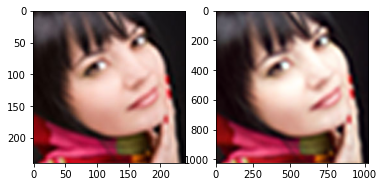

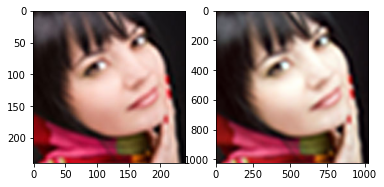

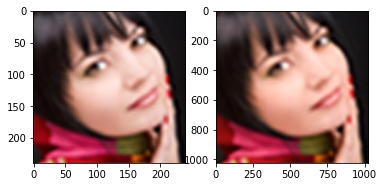

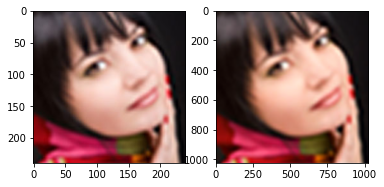

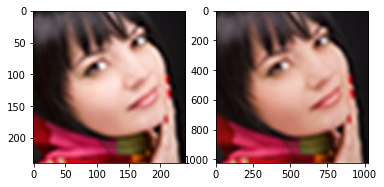

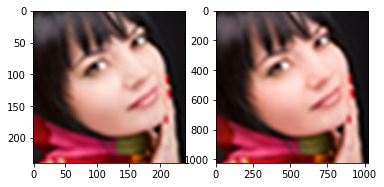

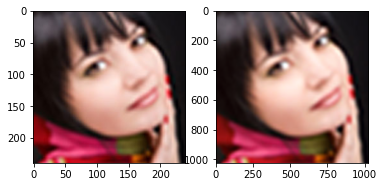

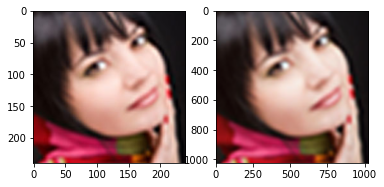

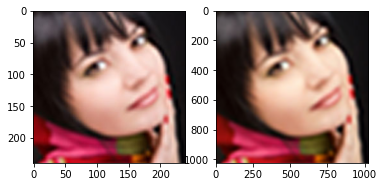

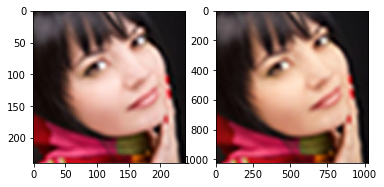

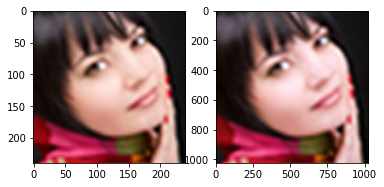

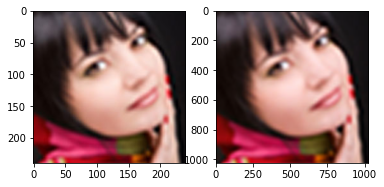

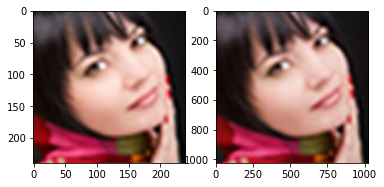

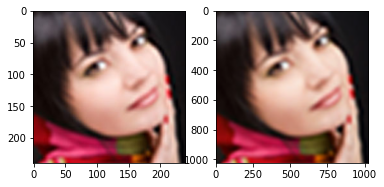

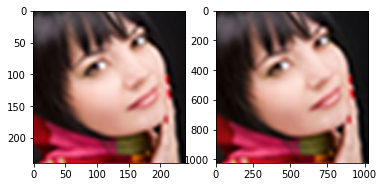

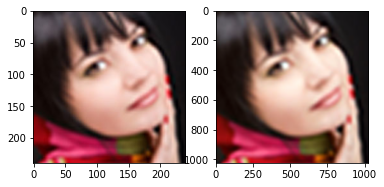

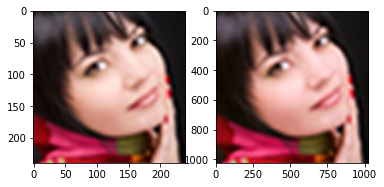

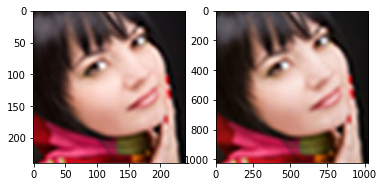

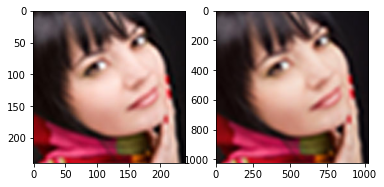

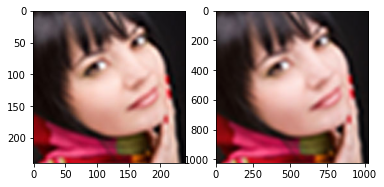

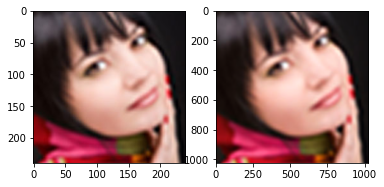

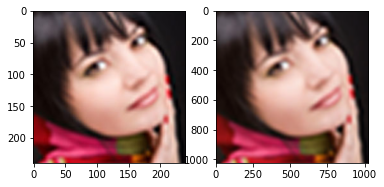

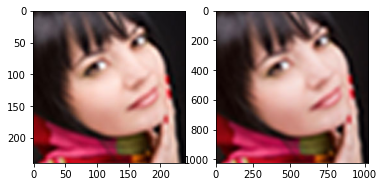

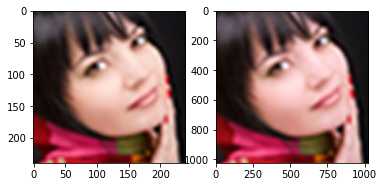

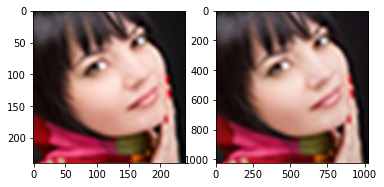

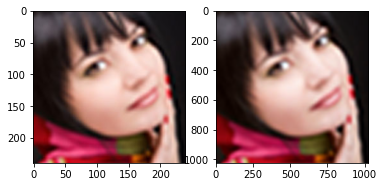

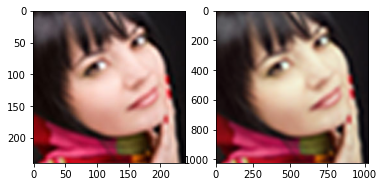

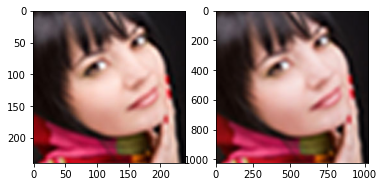

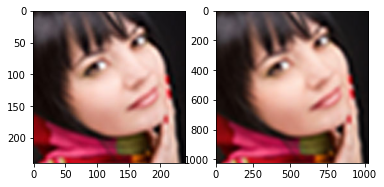

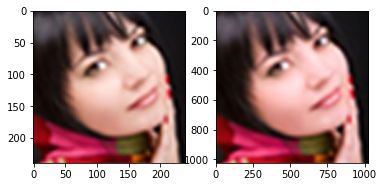

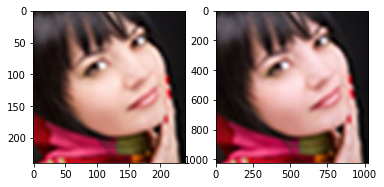

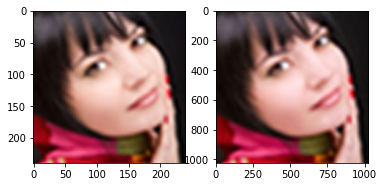

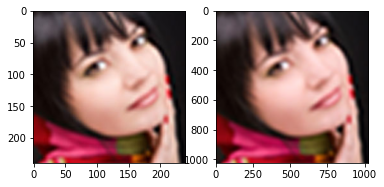

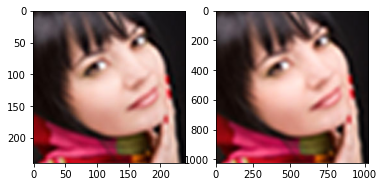

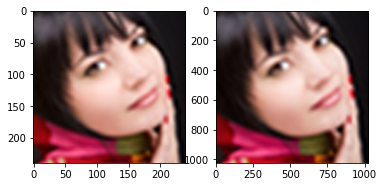

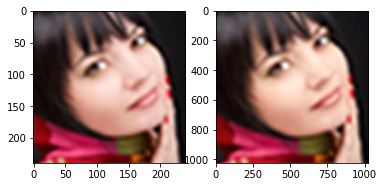

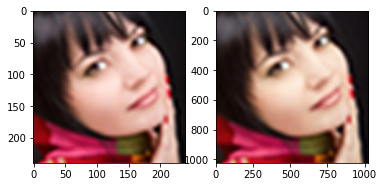

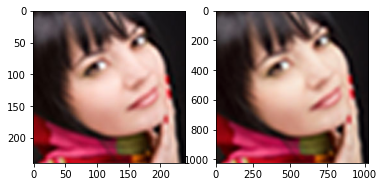

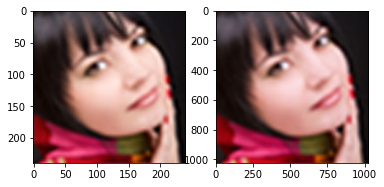

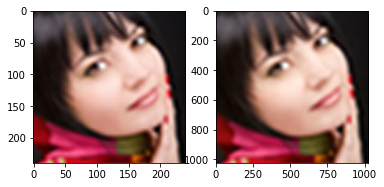

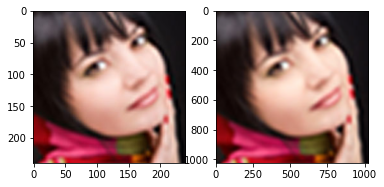

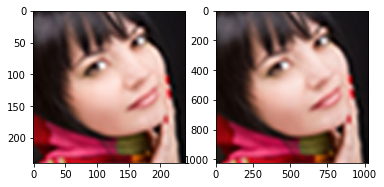

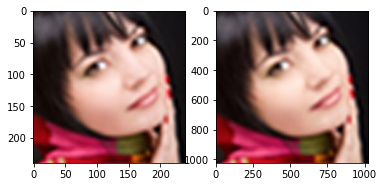

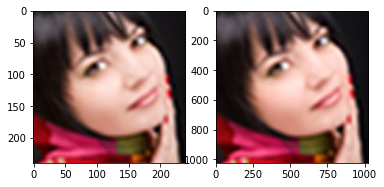

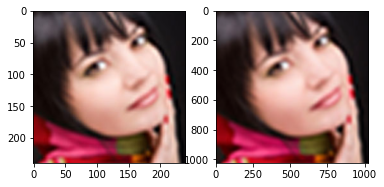

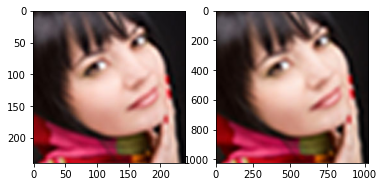

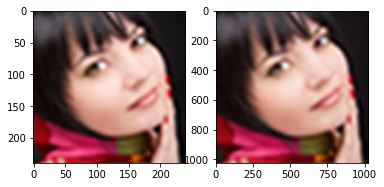

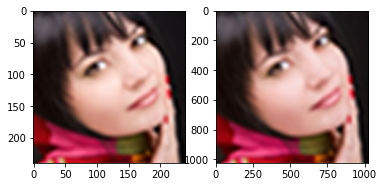

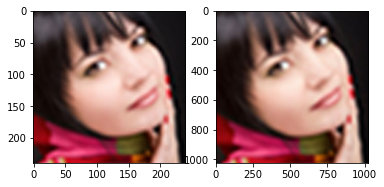

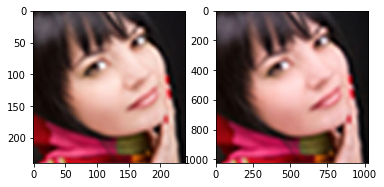

Error in callback <function flush_figures at 0x7fa10ffde3b0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
opts = AttrDict()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

args_dict = {
    'checkpoint': "/content/drive/MyDrive/CSC413/checkpoints/",
    'lr': 0.0001,
    'beta1':0.9,
    'beta2':0.999,
    'batch_size': 32,
    'device': device, 
    'epochs': 12,
    'num_workers': 4,
    'resume': False,
    'log_step': 100, 
    'checkpoint_every':1000,
    'train_iters':200000,
    'batch' : 'train_data_batch_1'
}

torch.autograd.set_detect_anomaly(True)
opts.update(args_dict)
train(opts)

In [ ]:
from torchvision.utils import save_image
from tifffile import imsave
import cv2 




def torch_to_saveable_image(image_est):
  image_est = image_est.cpu().clone().detach().numpy()
  image_est = np.transpose(image_est, (1,2,0))
  image_est = cv2.normalize(image_est, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  image_est = cv2.cvtColor(image_est, cv2.COLOR_RGB2BGR)
  return image_est


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")




load_opts = AttrDict()
args_dict = {
    'load': '/content/drive/MyDrive/CSC413/checkpoints/17000',
    'device': device
}

load_opts.update(args_dict)


G, _ = load_checkpoint(load_opts)

data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((64,64))
])


filename = "obama"
filetype = ".jpg"
directory = "/content/drive/MyDrive/CSC413/checkpoints/172000/"


image_name = directory + filename  + filetype
og_image = Image.open(image_name)
image = data_transforms(og_image).float()


image = torch.tensor(image, requires_grad=True)
image = image.unsqueeze(0).to(device)



image_est = G(image).squeeze(0)
image_est = torch_to_saveable_image(image_est)



bicubic = torchvision.transforms.Resize((256,256))
image =  image.squeeze(0)
bicubic = bicubic(image)
bicubic = torch_to_saveable_image(bicubic)

plt.imshow(image_est)
cv2.imwrite(directory + filename + "_SRGAN.png", image_est)
cv2.imwrite(directory + filename + "_bicubic.png", bicubic)



In [ ]:
!nvidia-smi

Sat Apr 10 21:09:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    35W / 250W |   3063MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------